In [1]:
# Konfiguracja startowa
import pickle

DO_TRAIN = False  # czy trenowanie ma być wykonane na nowo, czy wczytane z dysku (jak z dysku to też zbiór testowy jest z dysku, augmentacja itd.)

def load_cache(fn):
    with open(fn, 'rb') as cf:
        return pickle.load(cf)


def write_cache(fn, data):
    with open(fn, 'wb') as cf:
        pickle.dump(data, cf)

In [2]:
# Załadowanie hitów w PNG z katalogu hit-images-final2
# z podziałem na "dot", "track" i "worm" (podkatalogi)

from align_images_pca import align_image
from PIL import Image
import numpy as np
import glob


CACHE_IMAGES = 'cache/images.pickle'

DOTS_SRC = 'hit-images-final2/dot'
TRACKS_SRC = 'hit-images-final2/line'
WORMS_SRC = 'hit-images-final2/worms'


def load_images(src):
    images = []
    files = list(glob.glob("%s/*.png" % src))
    files = sorted(files)
    for image_path in files:
        img = Image.open(image_path)
        img = img.convert('L')
        image = np.asarray(img)
        #image = np.asarray(Image.open(image_path).convert('L'))
        image = align_image(image)
        mask = np.where(image > 25, 1, 0)
        image = mask * image
        image = image.astype(np.float32) / np.max(image)
        image = np.expand_dims(image, 2)
        images.append(image)
    return np.asarray(images), files


if DO_TRAIN:
    dots_set, dots_files = load_images(DOTS_SRC)
    tracks_set, tracks_files = load_images(TRACKS_SRC)
    worms_set, worms_files = load_images(WORMS_SRC)
    write_cache(CACHE_IMAGES, [dots_set, dots_files, tracks_set, tracks_files, worms_set, worms_files])
else:
    [dots_set, dots_files, tracks_set, tracks_files, worms_set, worms_files] = load_cache(CACHE_IMAGES)

print('len(dots_set): %d' % dots_set.shape[0])
print('len(tracks_set): %d' % tracks_set.shape[0])
print('len(worms_set): %d' % worms_set.shape[0])

len(dots_set): 1875
len(tracks_set): 3065
len(worms_set): 496


In [3]:
# przygotowanie jeszcze set'a z tracks i dots:
# * tnd - tracks and dots
# * tracks - tracks (już gotowy)

tnd_set = np.vstack([tracks_set, dots_set])
tnd_files = np.hstack([tracks_files, dots_files])

print('len(tnd_set): %d' % tnd_set.shape[0])

len(tnd_set): 4940


In [4]:
# augmentacja przez mirror, czyli pomnożenie próbek 2x przez dodanie lustrzanie odbitych

import pickle
CACHE_AUGMENTATION = 'cache/augmentation.pickle'

def augmentation_mirror(src, files):
    images = []
    files_aug = []
    for i in range(0, len(src)):
        img = src[i]
        images.append(img)
        images.append(np.flip(img))
        files_aug.append(files[i])
        files_aug.append(files[i])
    return np.asarray(images), files_aug

if DO_TRAIN:
    dots2_set, dots2_files = augmentation_mirror(dots_set, dots_files)
    tracks2_set, tracks2_files = augmentation_mirror(tracks_set, tracks_files)
    worms2_set, worms2_files = augmentation_mirror(worms_set, worms_files)
    tnd2_set, tnd2_files = augmentation_mirror(tnd_set, tnd_files)
    write_cache(CACHE_AUGMENTATION, [dots2_set, dots2_files, tracks2_set, tracks2_files, worms2_set, worms2_files, tnd2_set, tnd2_files])
else:
    [dots2_set, dots2_files, tracks2_set, tracks2_files, worms2_set, worms2_files, tnd2_set, tnd2_files] = load_cache(CACHE_AUGMENTATION)

print('len(dots2_set): %d' % dots2_set.shape[0])
print('len(tracks2_set): %d' % tracks2_set.shape[0])
print('len(worms2_set): %d' % worms2_set.shape[0])
print('len(tnd2_set): %d' % tnd2_set.shape[0])

len(dots2_set): 3750
len(tracks2_set): 6130
len(worms2_set): 992
len(tnd2_set): 9880


In [5]:
# wygenerowanie zbioru train, validate i test o proporcjach odpowiednio 60%, 20% i 20%
# zwracane listy zawierają indeksy próbek, które zostały przydzielone do ww. ziorów

import pickle
CACHE_DIV = 'cache/sets_tvt.pickle'

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    p = np.random.permutation(df.shape[0])
    n = int(train_percent * len(p))
    m = int(validate_percent * len(p)) + n
    train = p[:n]
    validation = p[n:m]
    test = p[m:]
    return train, validation, test

if DO_TRAIN:
    dots2_train, dots2_validate, dots2_test = train_validate_test_split(dots2_set)
    tracks2_train, tracks2_validate, tracks2_test = train_validate_test_split(tracks2_set)
    worms2_train, worms2_validate, worms2_test = train_validate_test_split(worms2_set)
    tnd2_train, tnd2_validate, tnd2_test = train_validate_test_split(tnd2_set)
    write_cache(CACHE_DIV, [dots2_train, dots2_validate, dots2_test, tracks2_train, tracks2_validate, tracks2_test, worms2_train, worms2_validate, worms2_test, tnd2_train, tnd2_validate, tnd2_test])
else:
    [dots2_train, dots2_validate, dots2_test, tracks2_train, tracks2_validate, tracks2_test, worms2_train, worms2_validate, worms2_test, tnd2_train, tnd2_validate, tnd2_test] = load_cache(CACHE_DIV)

print('len(dots2_set): %d/%d/%d' % (dots2_train.shape[0], dots2_validate.shape[0], dots2_test.shape[0]))
print('len(tracks2_set): %d/%d/%d' % (tracks2_train.shape[0], tracks2_validate.shape[0], tracks2_test.shape[0]))
print('len(worms2_set): %d/%d/%d' % (worms2_train.shape[0], worms2_validate.shape[0], worms2_test.shape[0]))
print('len(tnd2_set): %d/%d/%d' % (tnd2_train.shape[0], tnd2_validate.shape[0], tnd2_test.shape[0]))

len(dots2_set): 2250/750/750
len(tracks2_set): 3678/1226/1226
len(worms2_set): 595/198/199
len(tnd2_set): 5928/1976/1976


In [6]:
# wytrenowanie kanałów
# * tracks
# * tnd (tracks and dots)

from commons import *
from dataset_loader import load_from_file
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

#DOTS_DST = 'cache/dots_100000.pickle'
#ARTIFACTS_DST = 'cache/artifacts_100000.pickle'

#DOTS_AC = 'cache/dots_100000.h5'
#TRACKS_AC = 'cache/th_dots_optics_100000.h5'
#WORMS_AC = 'cache/worms_100000.h5'
#ARTIFACTS_AC = 'cache/artifacts_100000.h5'
TRACKS_AC = 'cache/th_tracks_%d.h5'
TND_AC = 'cache/th_tnd_%d.h5'

def train_and_test(train_set, validation_set, fn_template, latentDim=16):
    fn = fn_template % latentDim
    autoencoder = original_autoencoder(latentDim=latentDim)
    autoencoder = train_or_cache(train_set, autoencoder, fn, validation_set=validation_set, force_train=True, latentDim=latentDim)

    for df_func, df_name in zip(
            [dm_func_mean],
            ['mean']
    ):
        for img_set, set_names in zip([validation_set], ['train']):
            decoded = autoencoder.predict(img_set)

            vis, errors = visualize_predictions(decoded, img_set, df_func, False, 16)
            img_path = fn.replace('.h5', '-vis.png')
            hist_path = fn.replace('.h5', '-hist.png')
            cv2.imwrite(img_path, vis)
            display(Image.open(img_path))
            if len(img_set) > 256:
                vis, errors = visualize_predictions(decoded, img_set, df_func, False)
                img_path = fn.replace('.h5', '-vis_full.png')
                cv2.imwrite(img_path, vis)

            plt.figure(figsize=(8,6))
            plt.hist(errors, bins=100, alpha=0.5, label=set_names)
            plt.xlabel("Data", size=14)
            plt.ylabel("Count", size=14)
            plt.title(df_name)
            plt.legend(loc='upper right')
            plt.savefig(hist_path)

if DO_TRAIN:
    train_and_test(tracks2_set[tracks2_train], tracks2_set[tracks2_validate], TRACKS_AC, 16)
    train_and_test(tnd2_set[tnd2_train], tnd2_set[tnd2_validate], TND_AC, 16)

320
0
128
18496
0
256
0
28802
43200
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 30, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 15, 15, 64)        0   

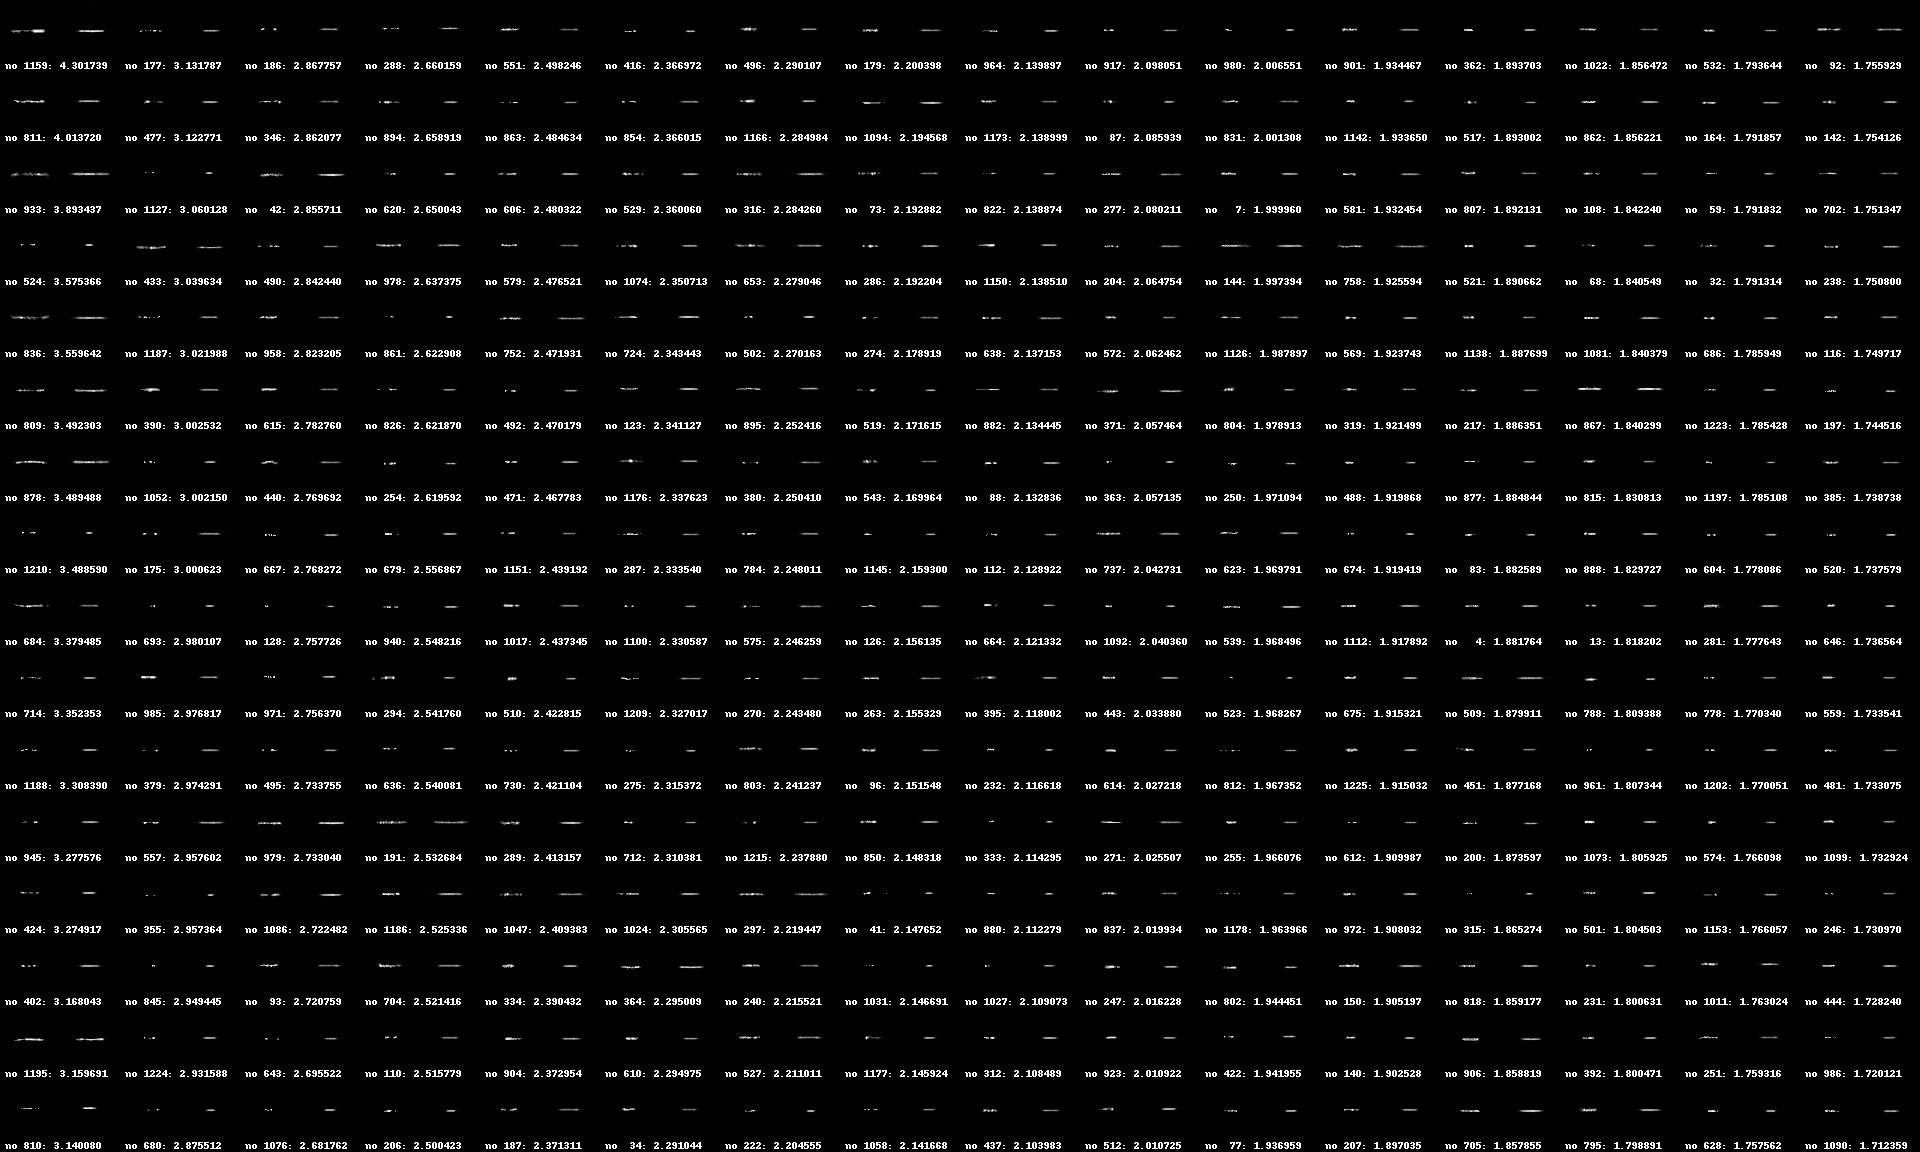

320
0
128
18496
0
256
0
28802
43200
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 15, 15, 64)        0   

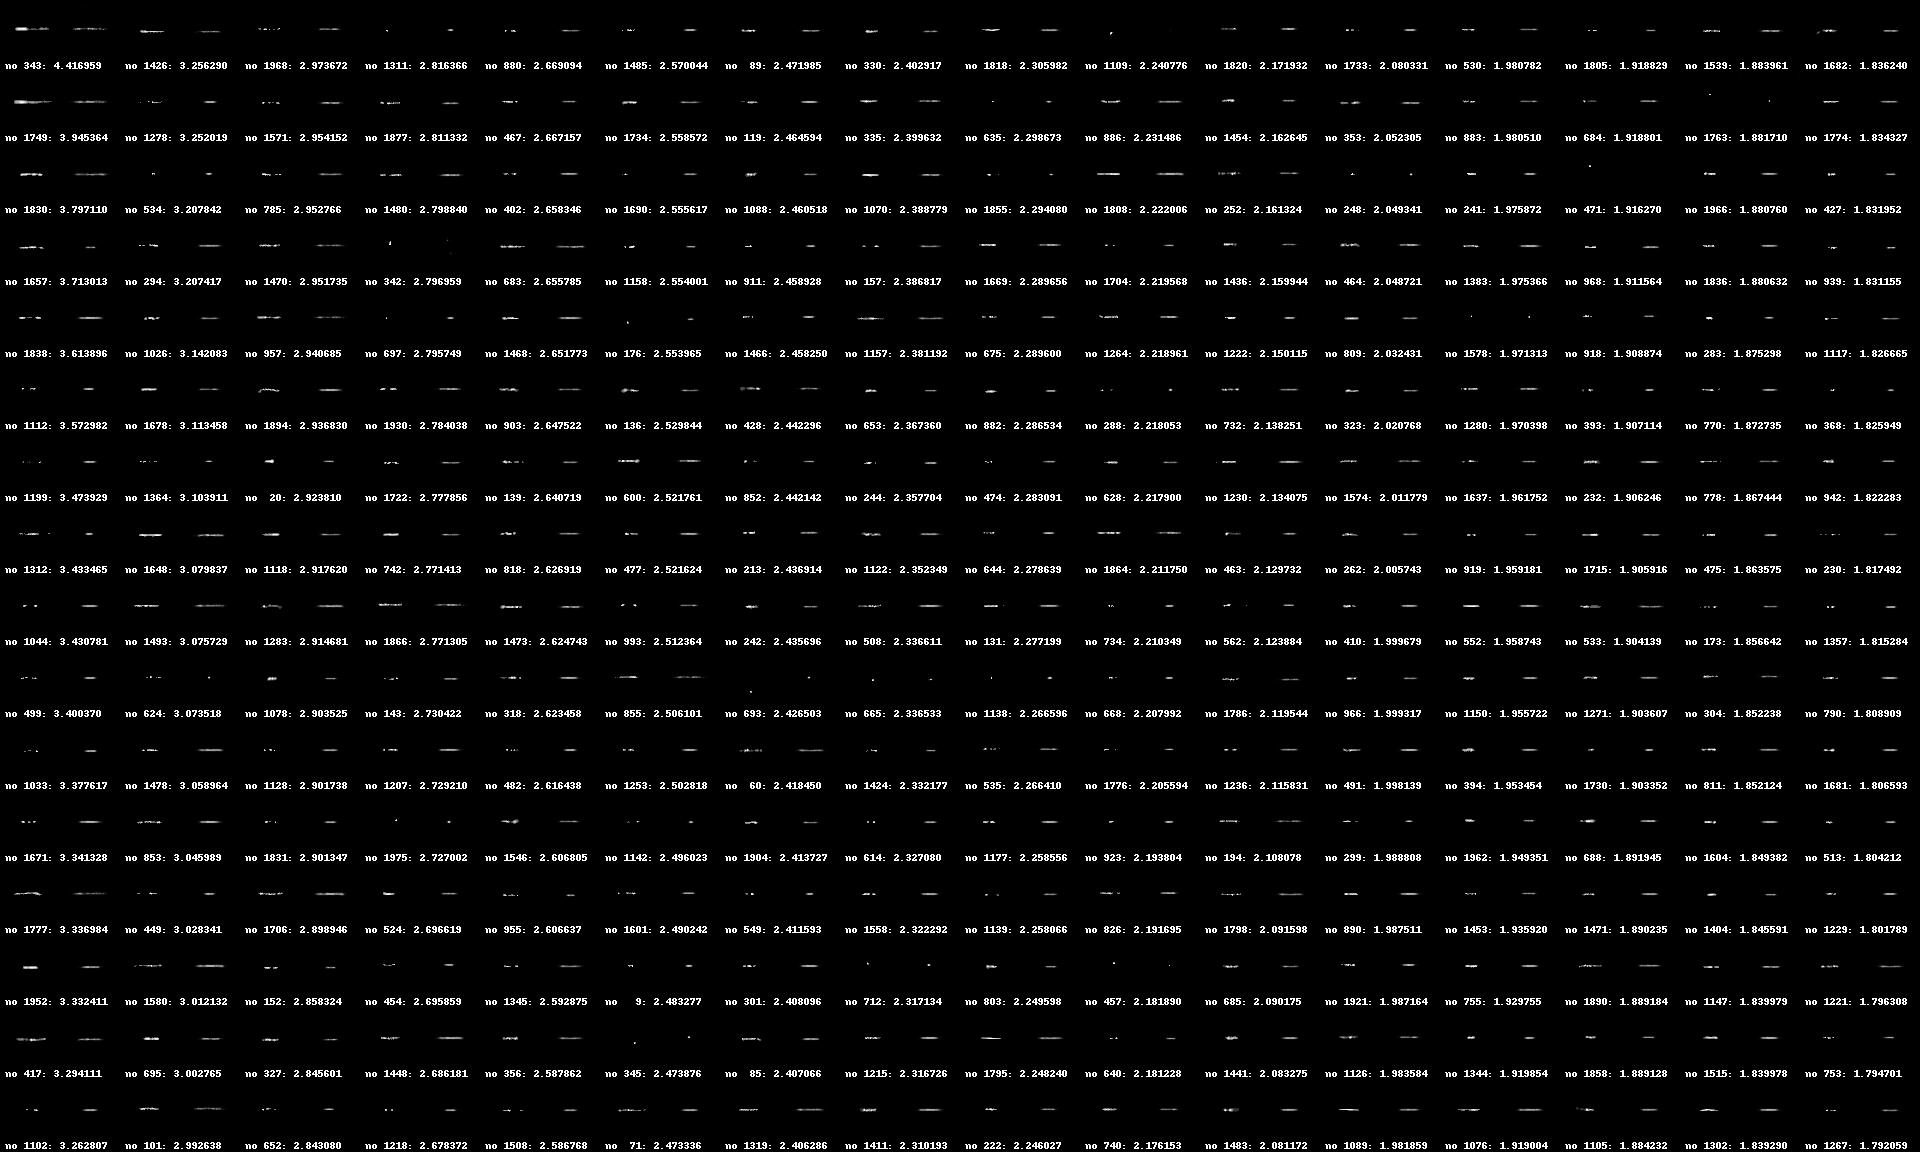

320
0
128
18496
0
256
0
57604
72000
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 15, 15, 64)        0   

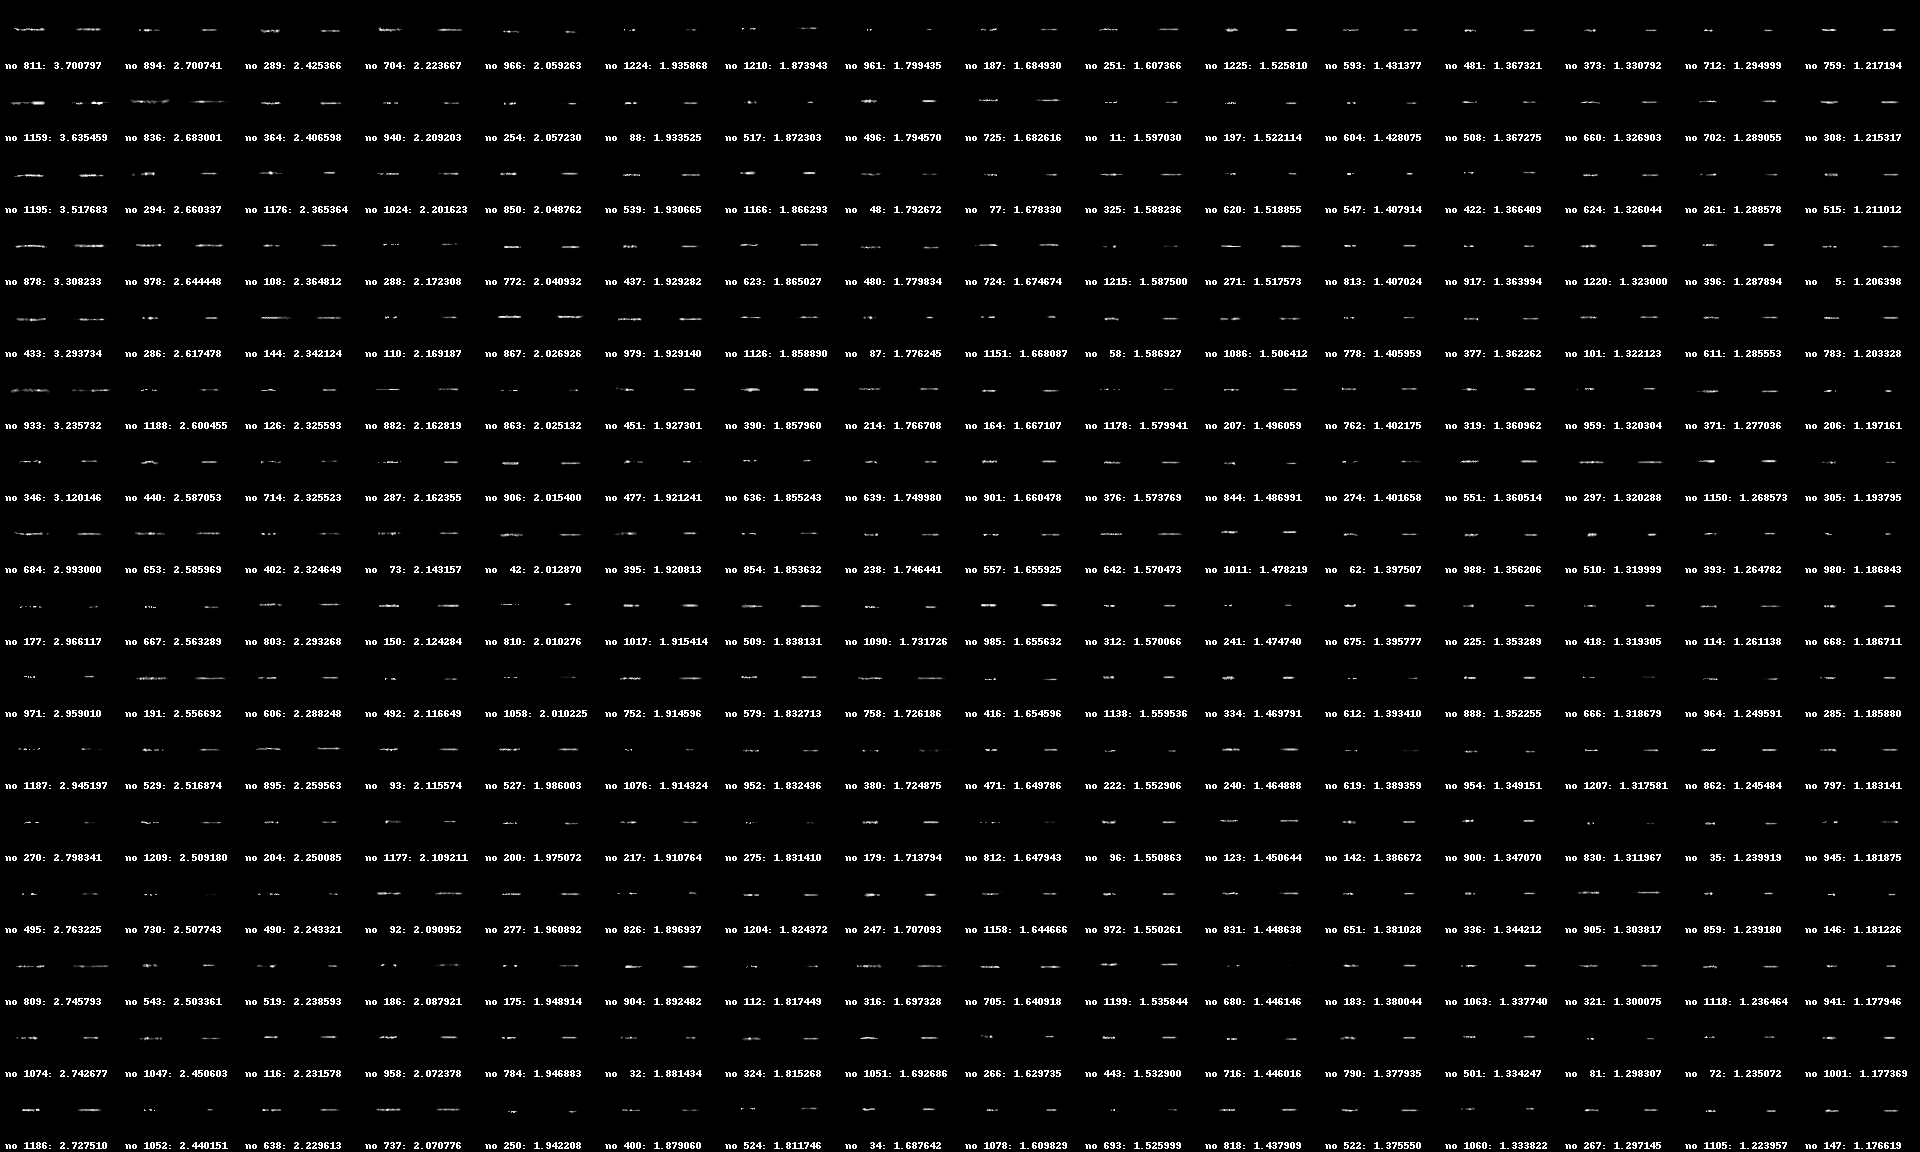

320
0
128
18496
0
256
0
57604
72000
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 15, 15, 64)        0   

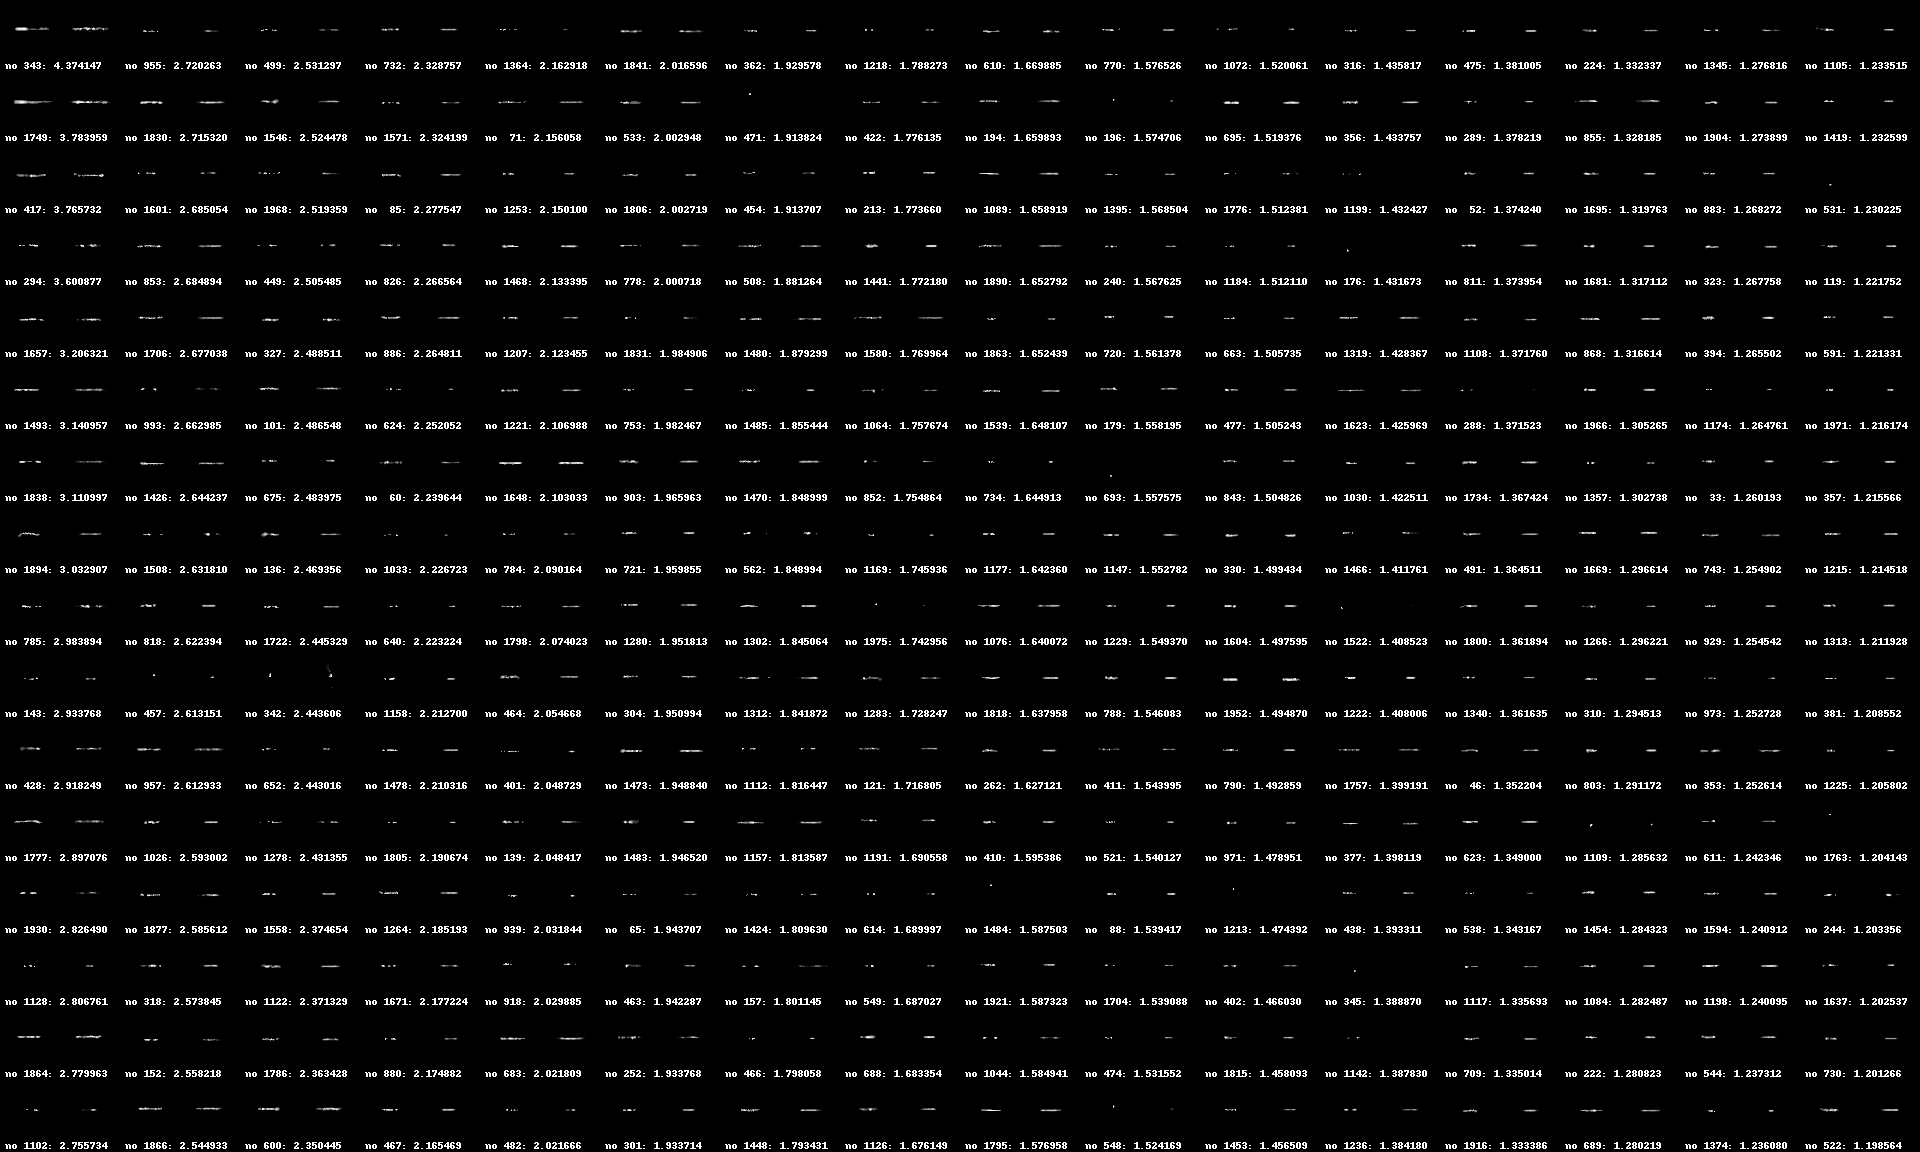

320
0
128
18496
0
256
0
86406
100800
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_16 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 15, 15, 64)        0  

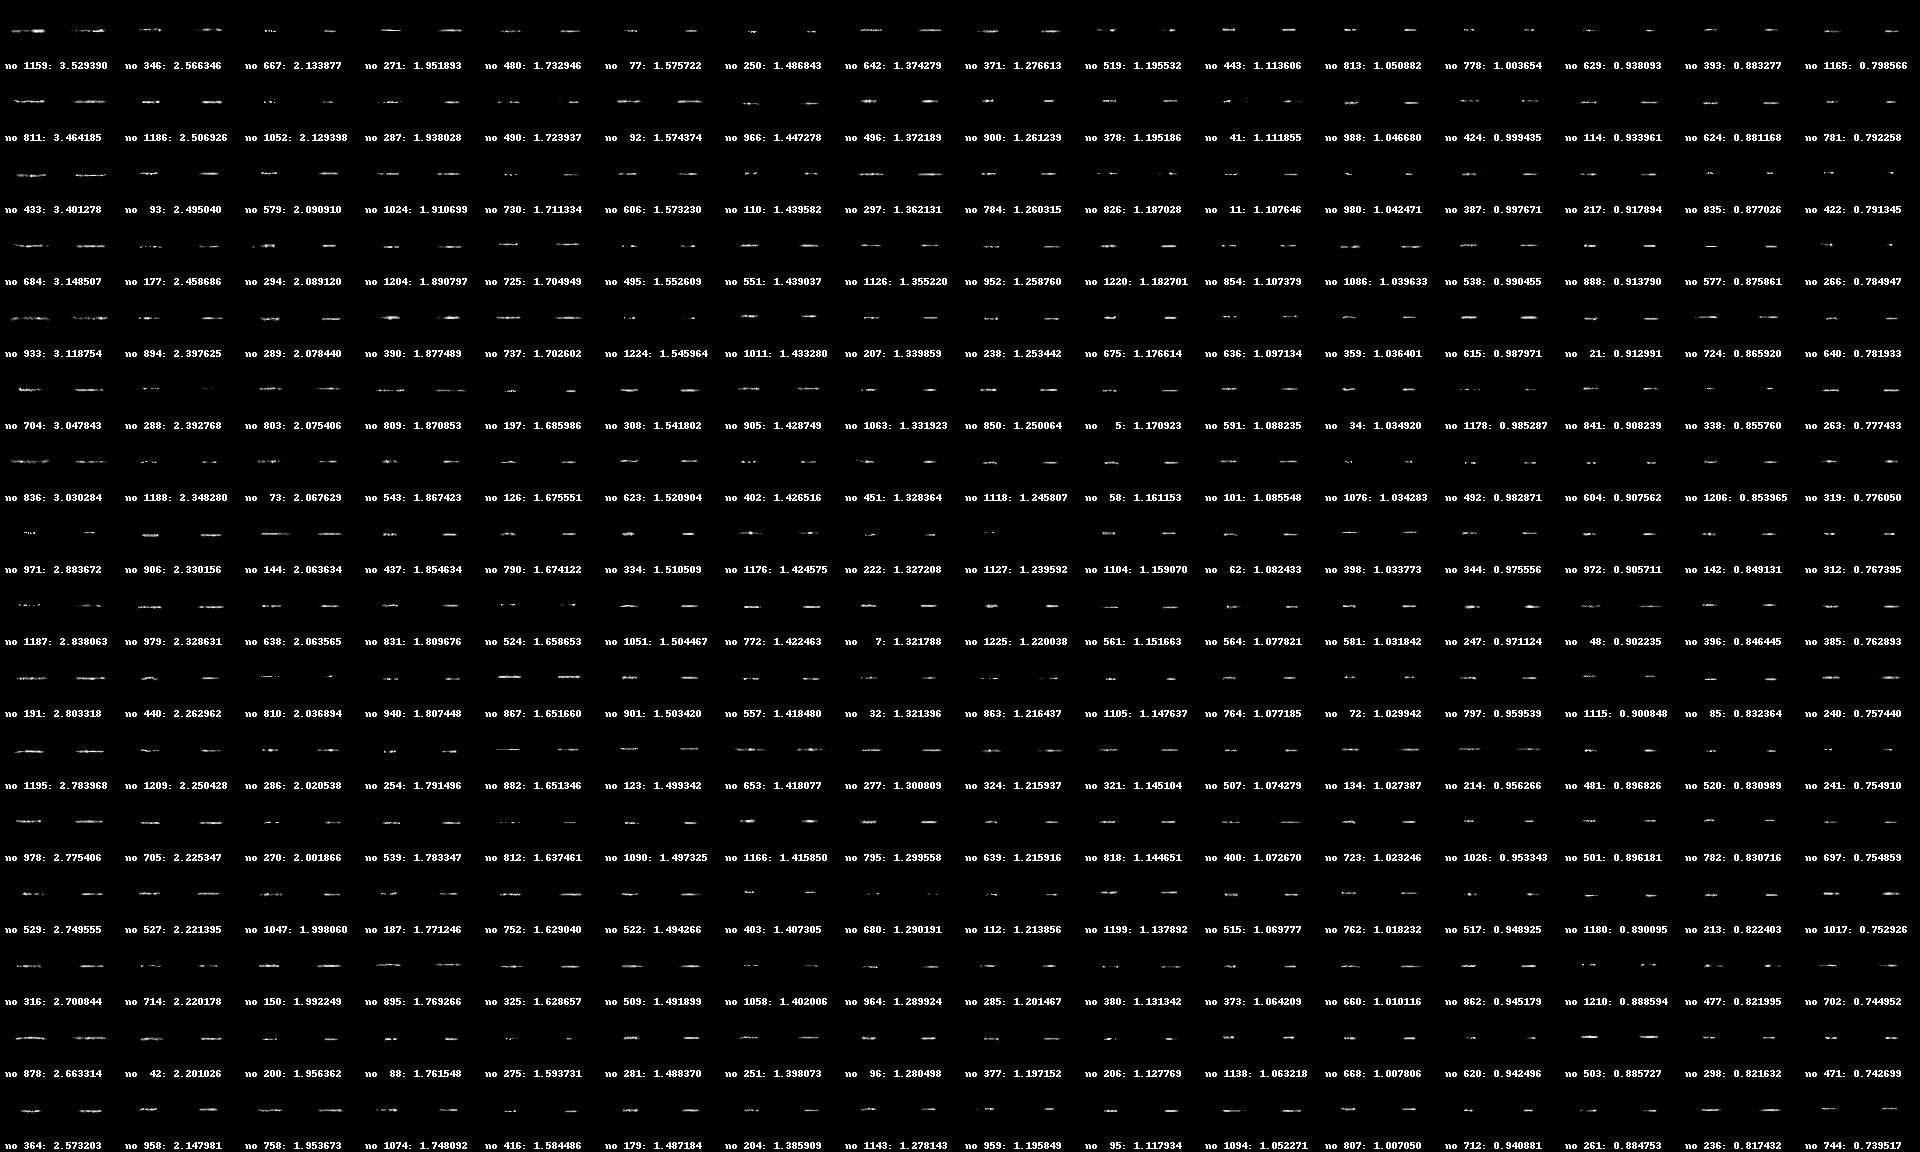

320
0
128
18496
0
256
0
86406
100800
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_20 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 15, 15, 64)        0  

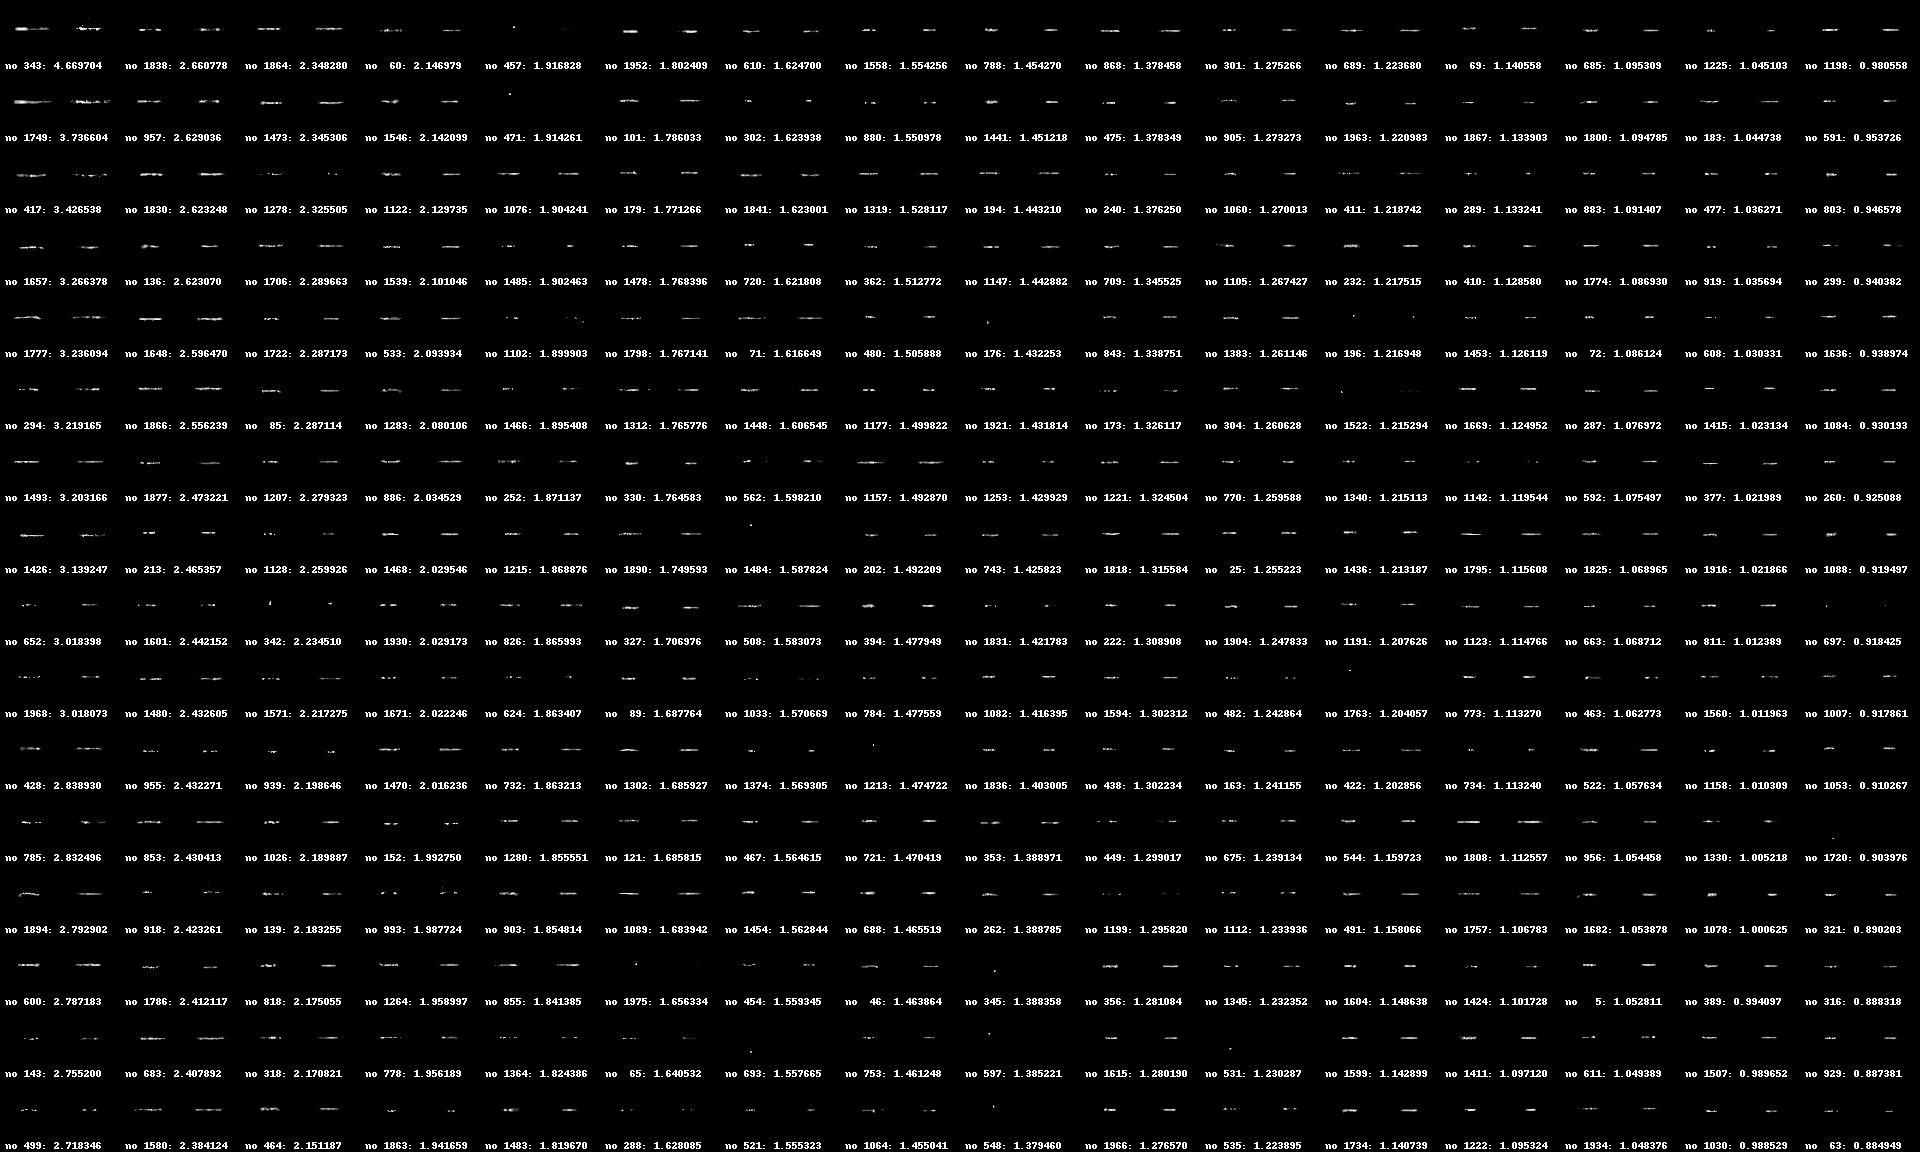

320
0
128
18496
0
256
0
115208
129600
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_24 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 15, 15, 64)        0 

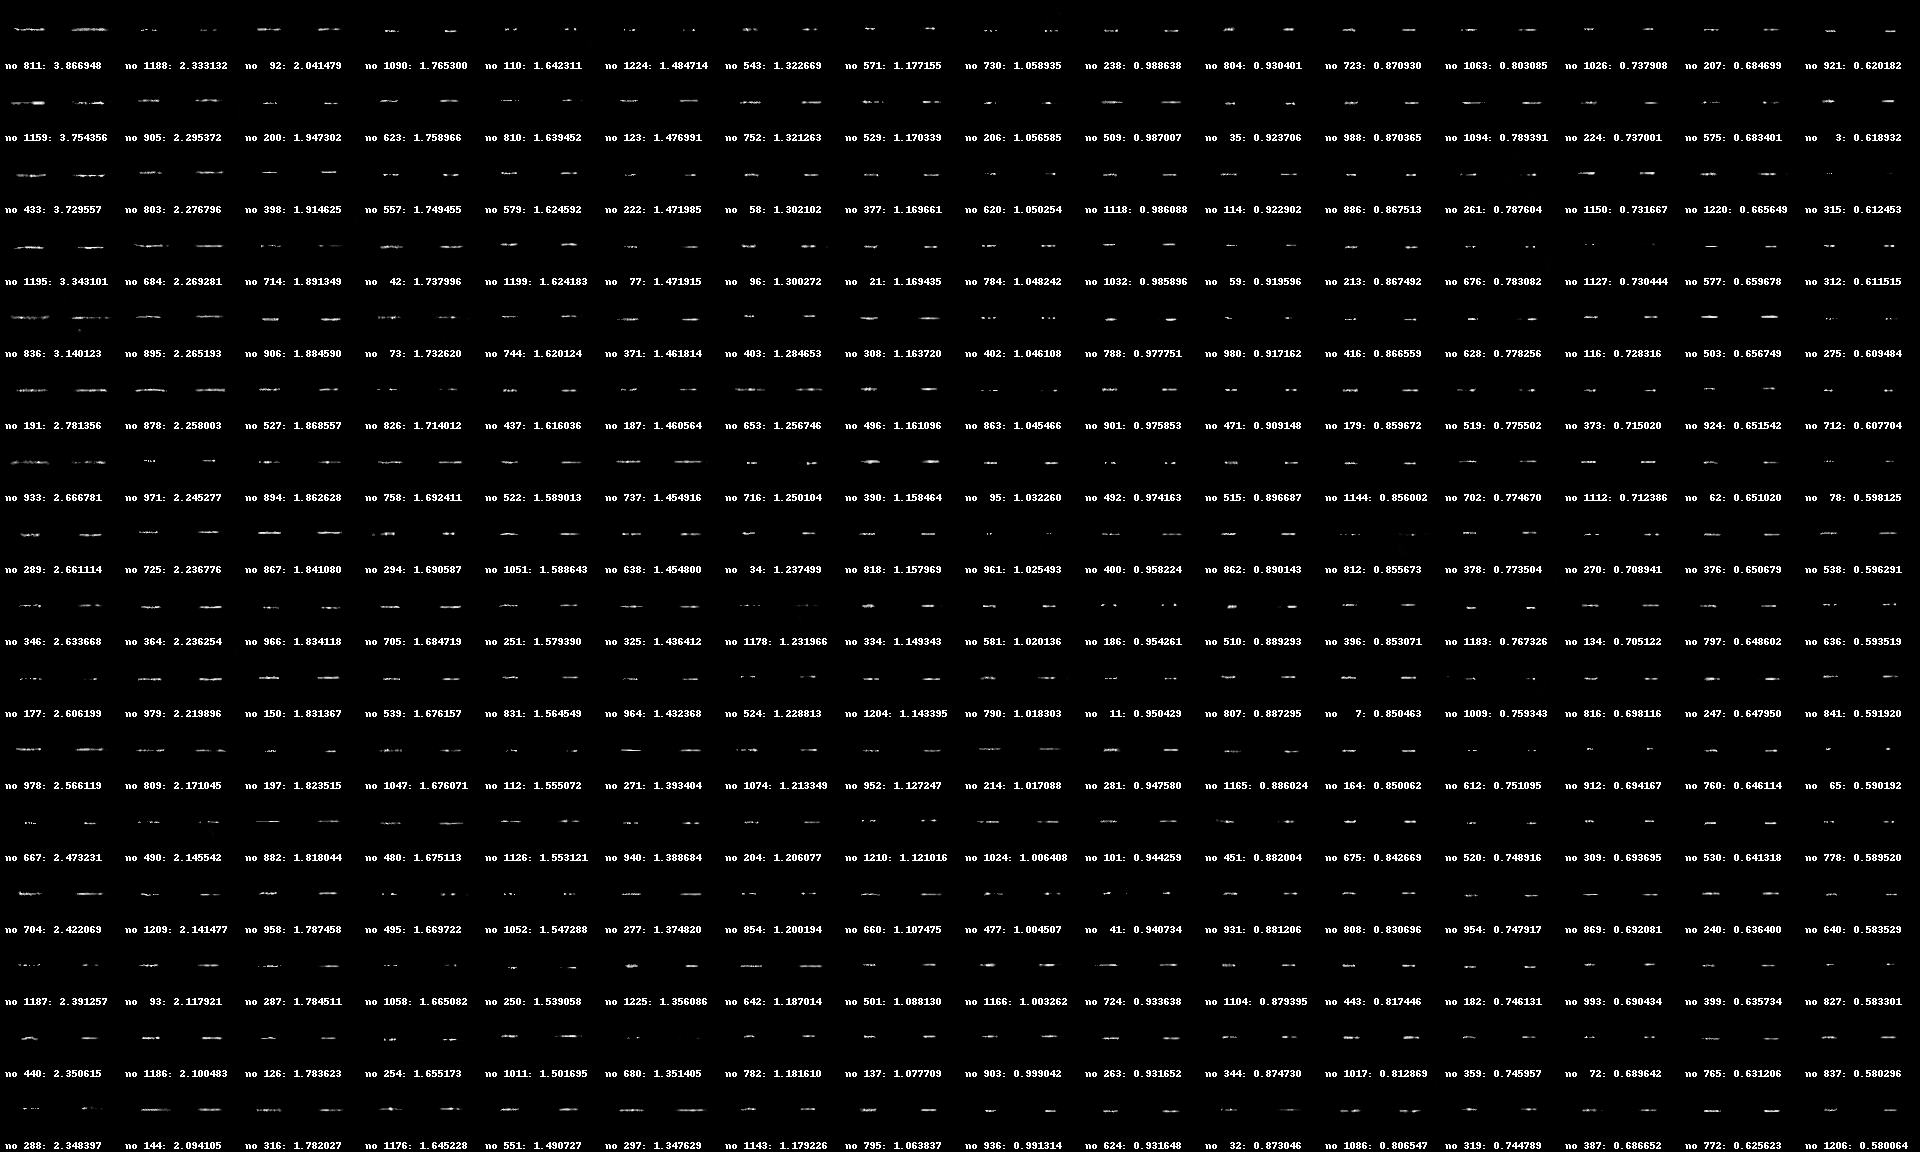

C:\Users\nkg75\AppData\Local\Temp\ipykernel_23080\2838582864.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6))


320
0
128
18496
0
256
0
115208
129600
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_28 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 15, 15, 64)        0 

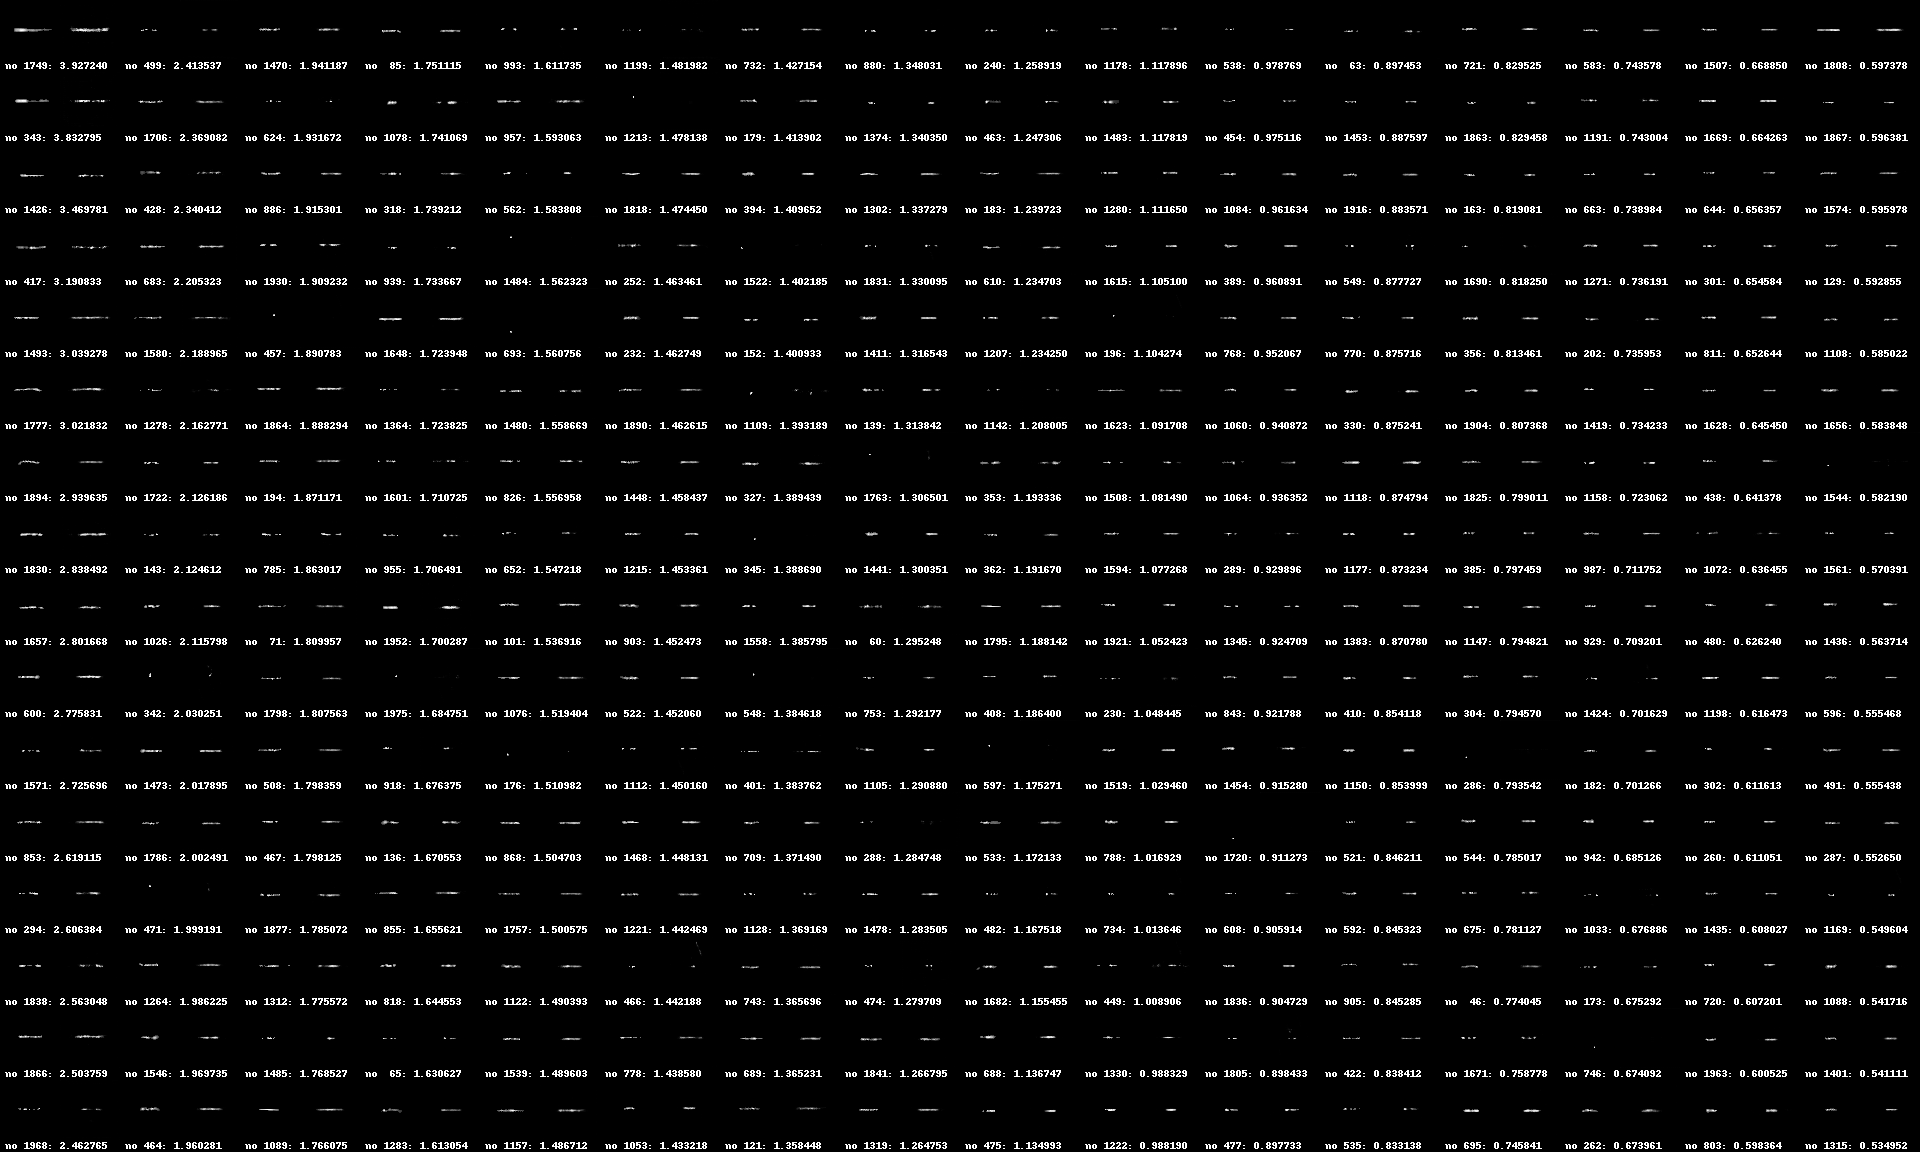

320
0
128
18496
0
256
0
172812
187200
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_32 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 15, 15, 64)        0 

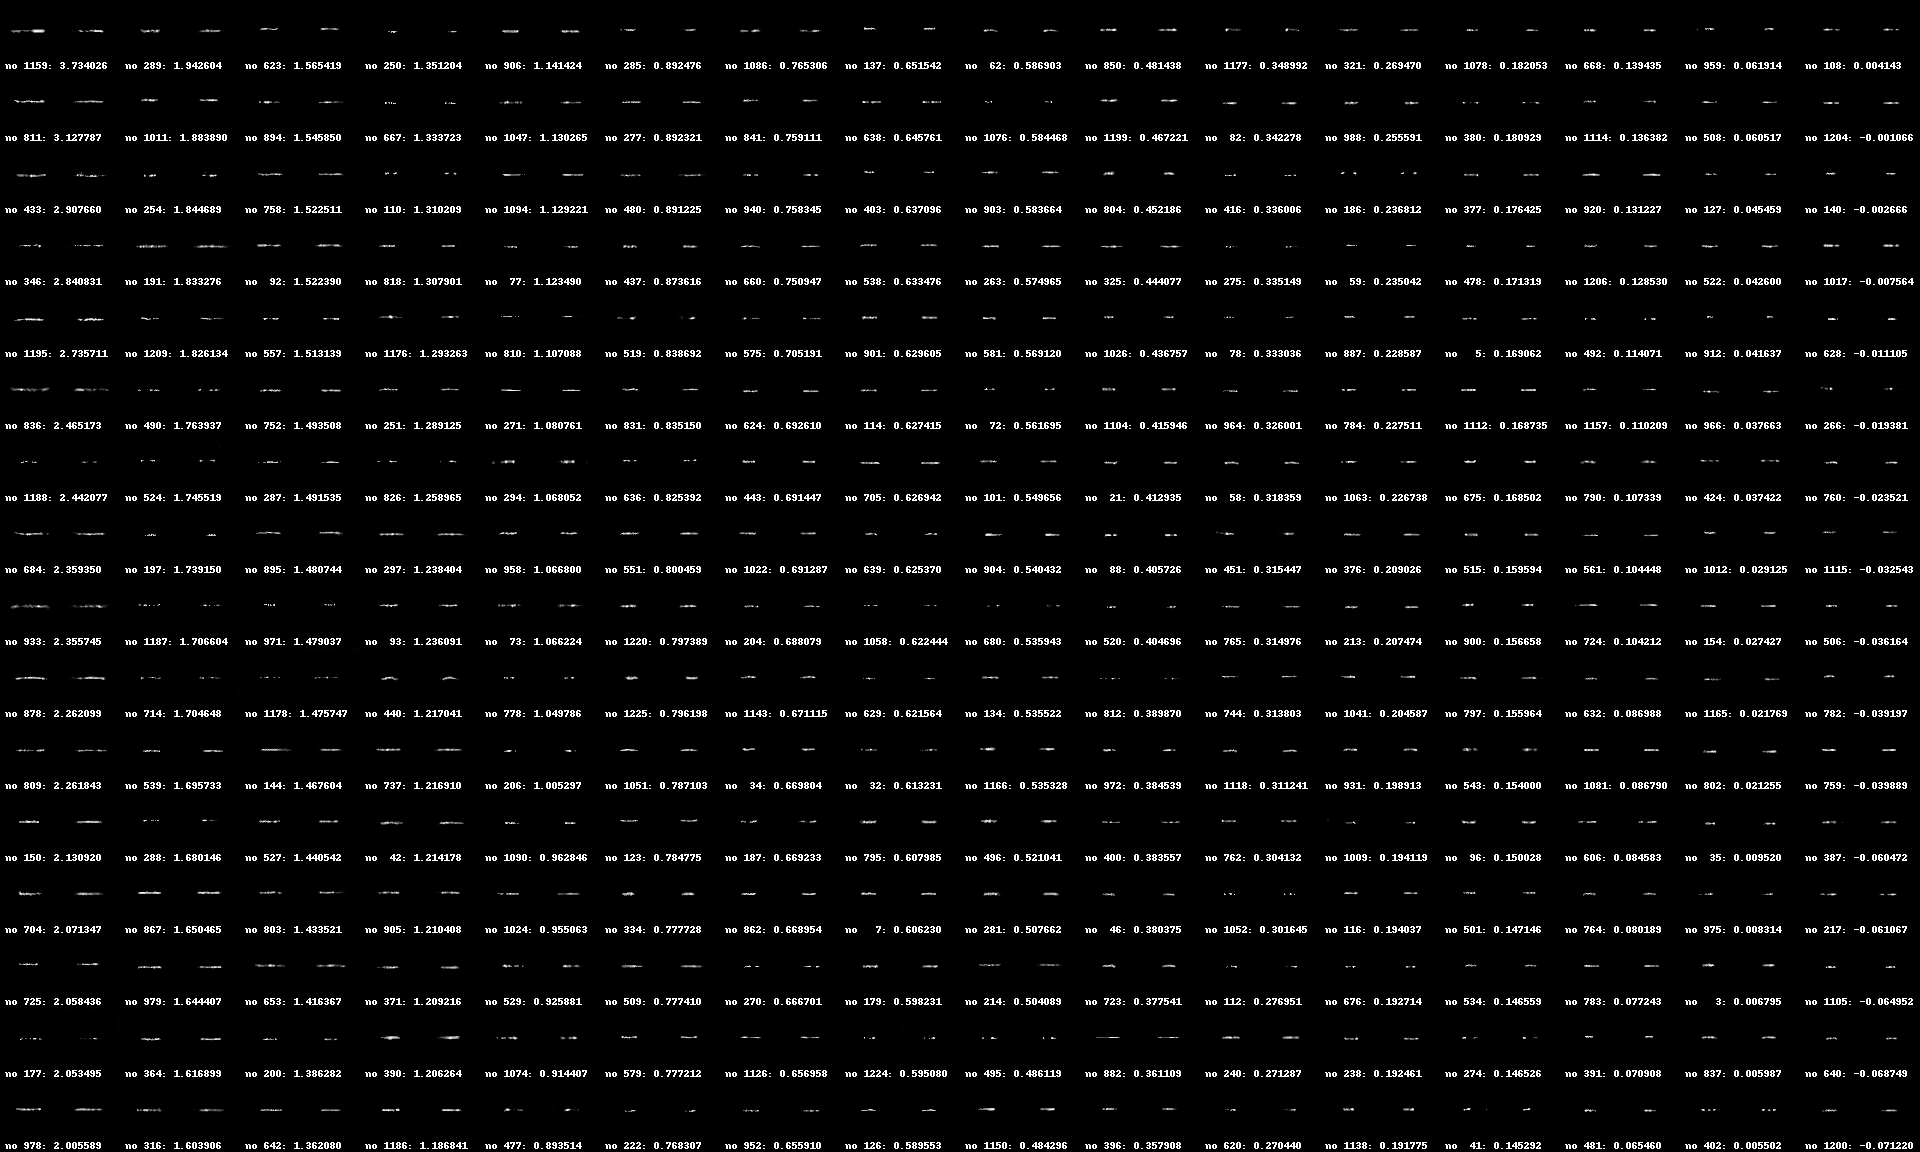

320
0
128
18496
0
256
0
172812
187200
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_36 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 15, 15, 64)        0 

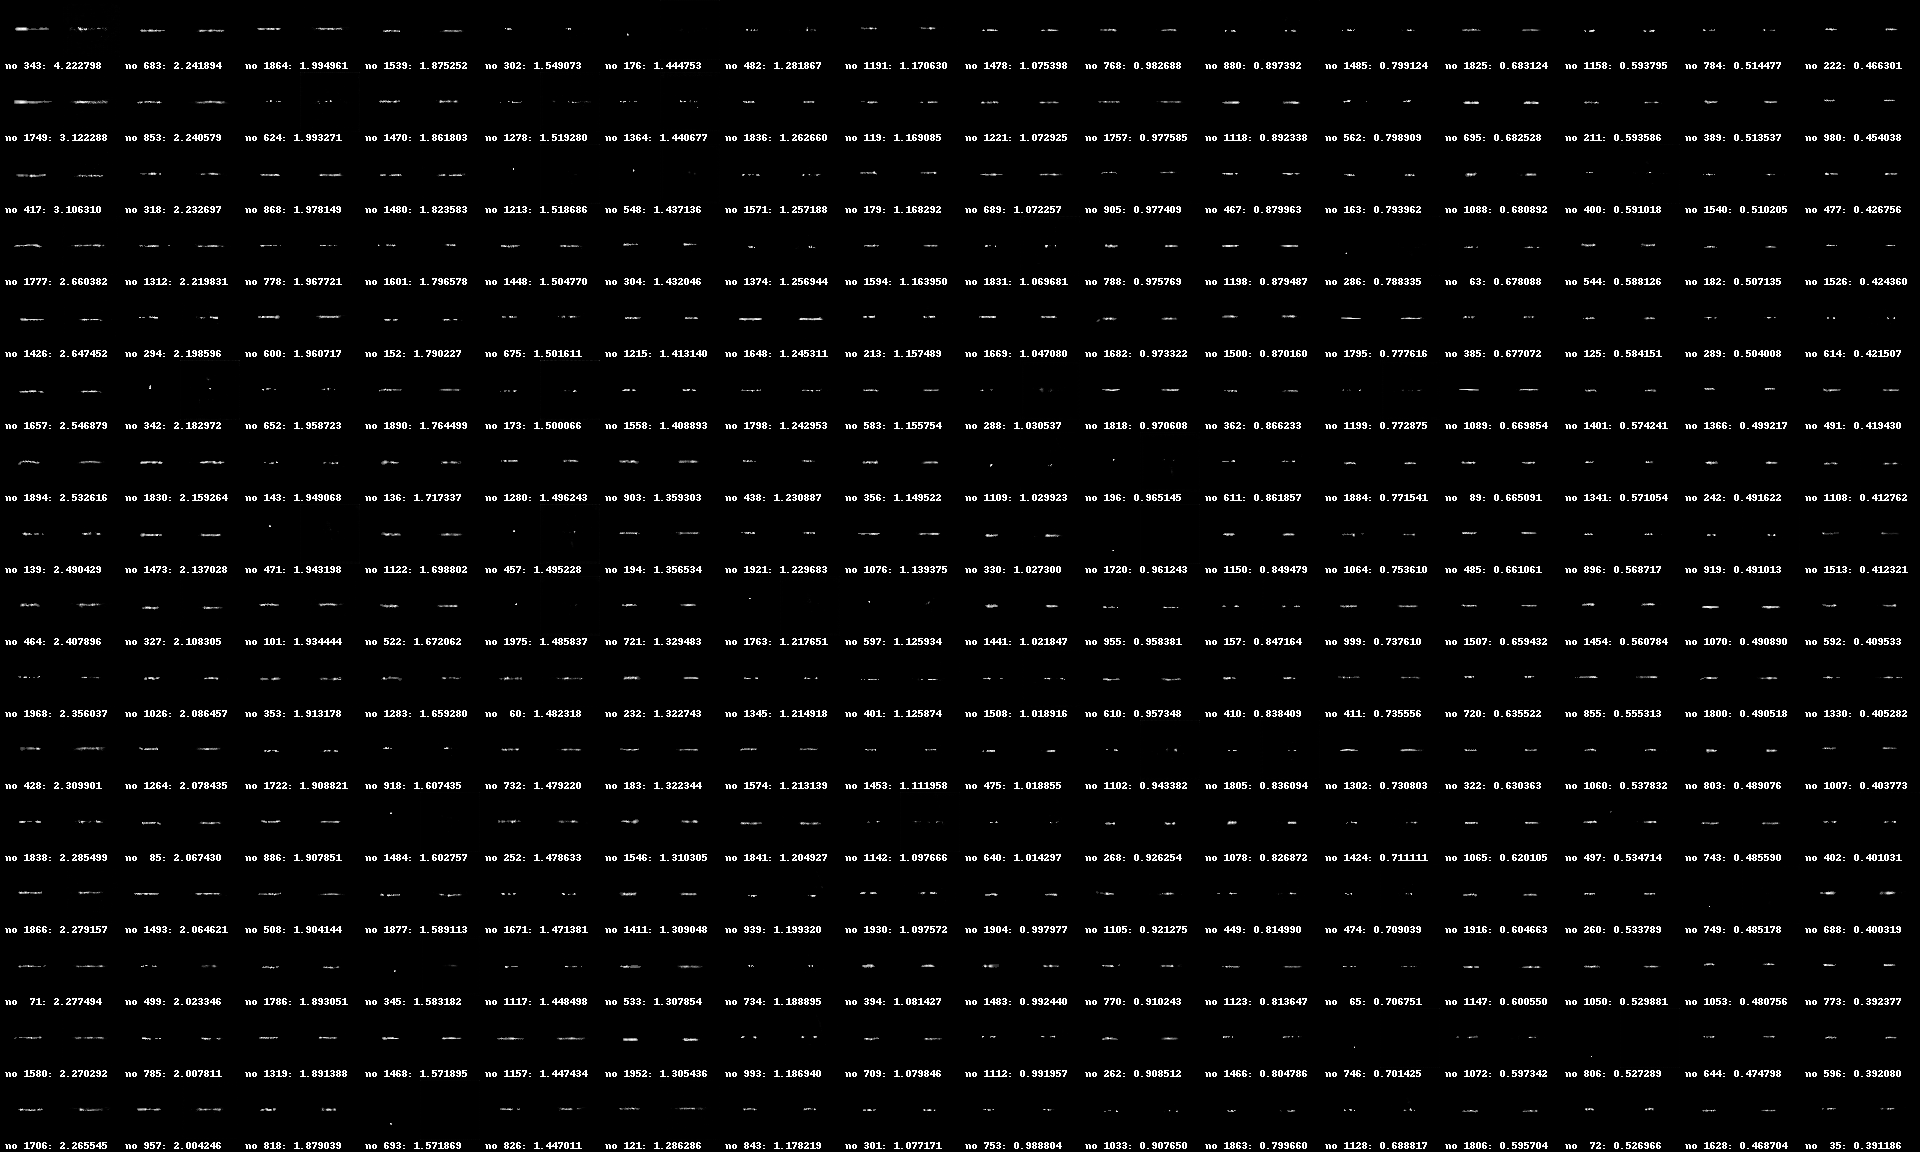

320
0
128
18496
0
256
0
345624
360000
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_40 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 15, 15, 64)        0 

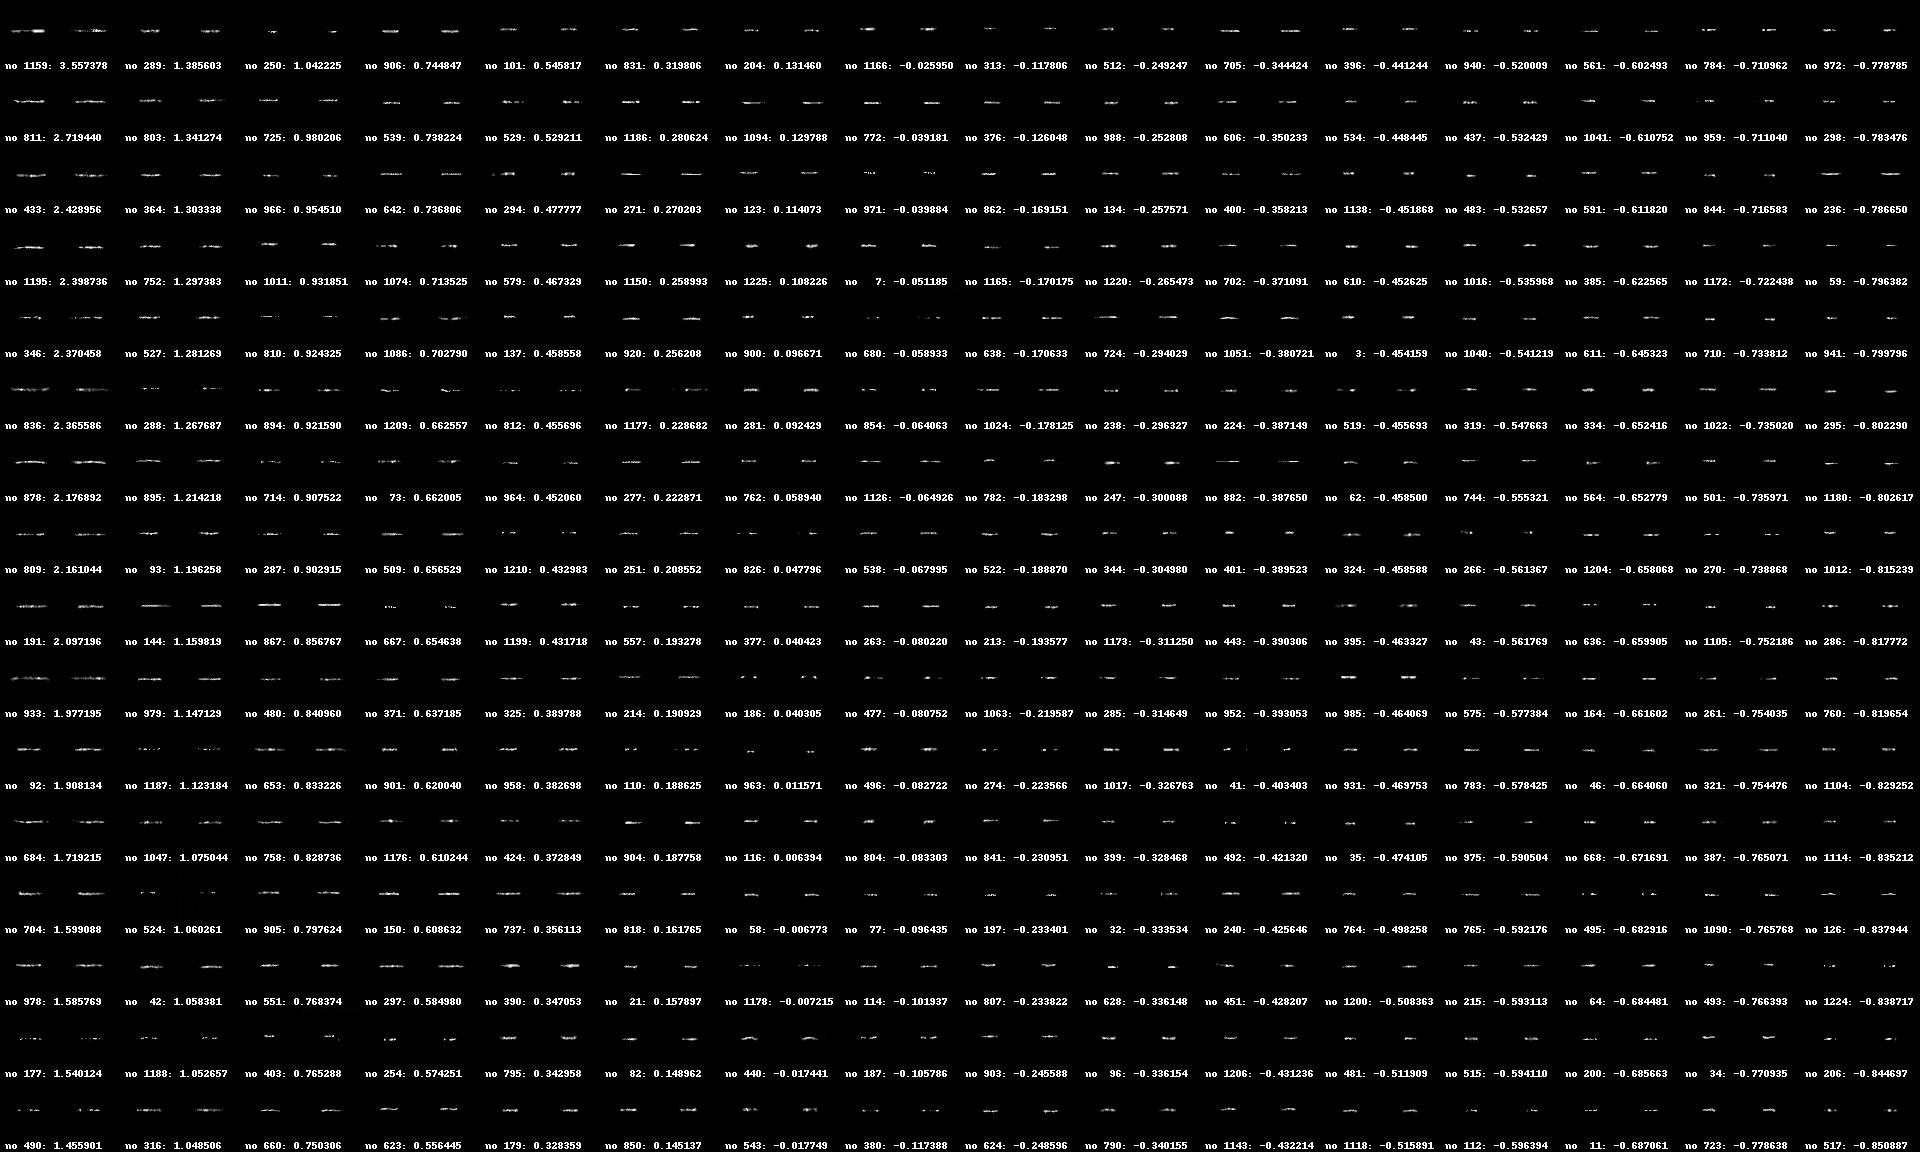

320
0
128
18496
0
256
0
345624
360000
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_44 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 15, 15, 64)        0 

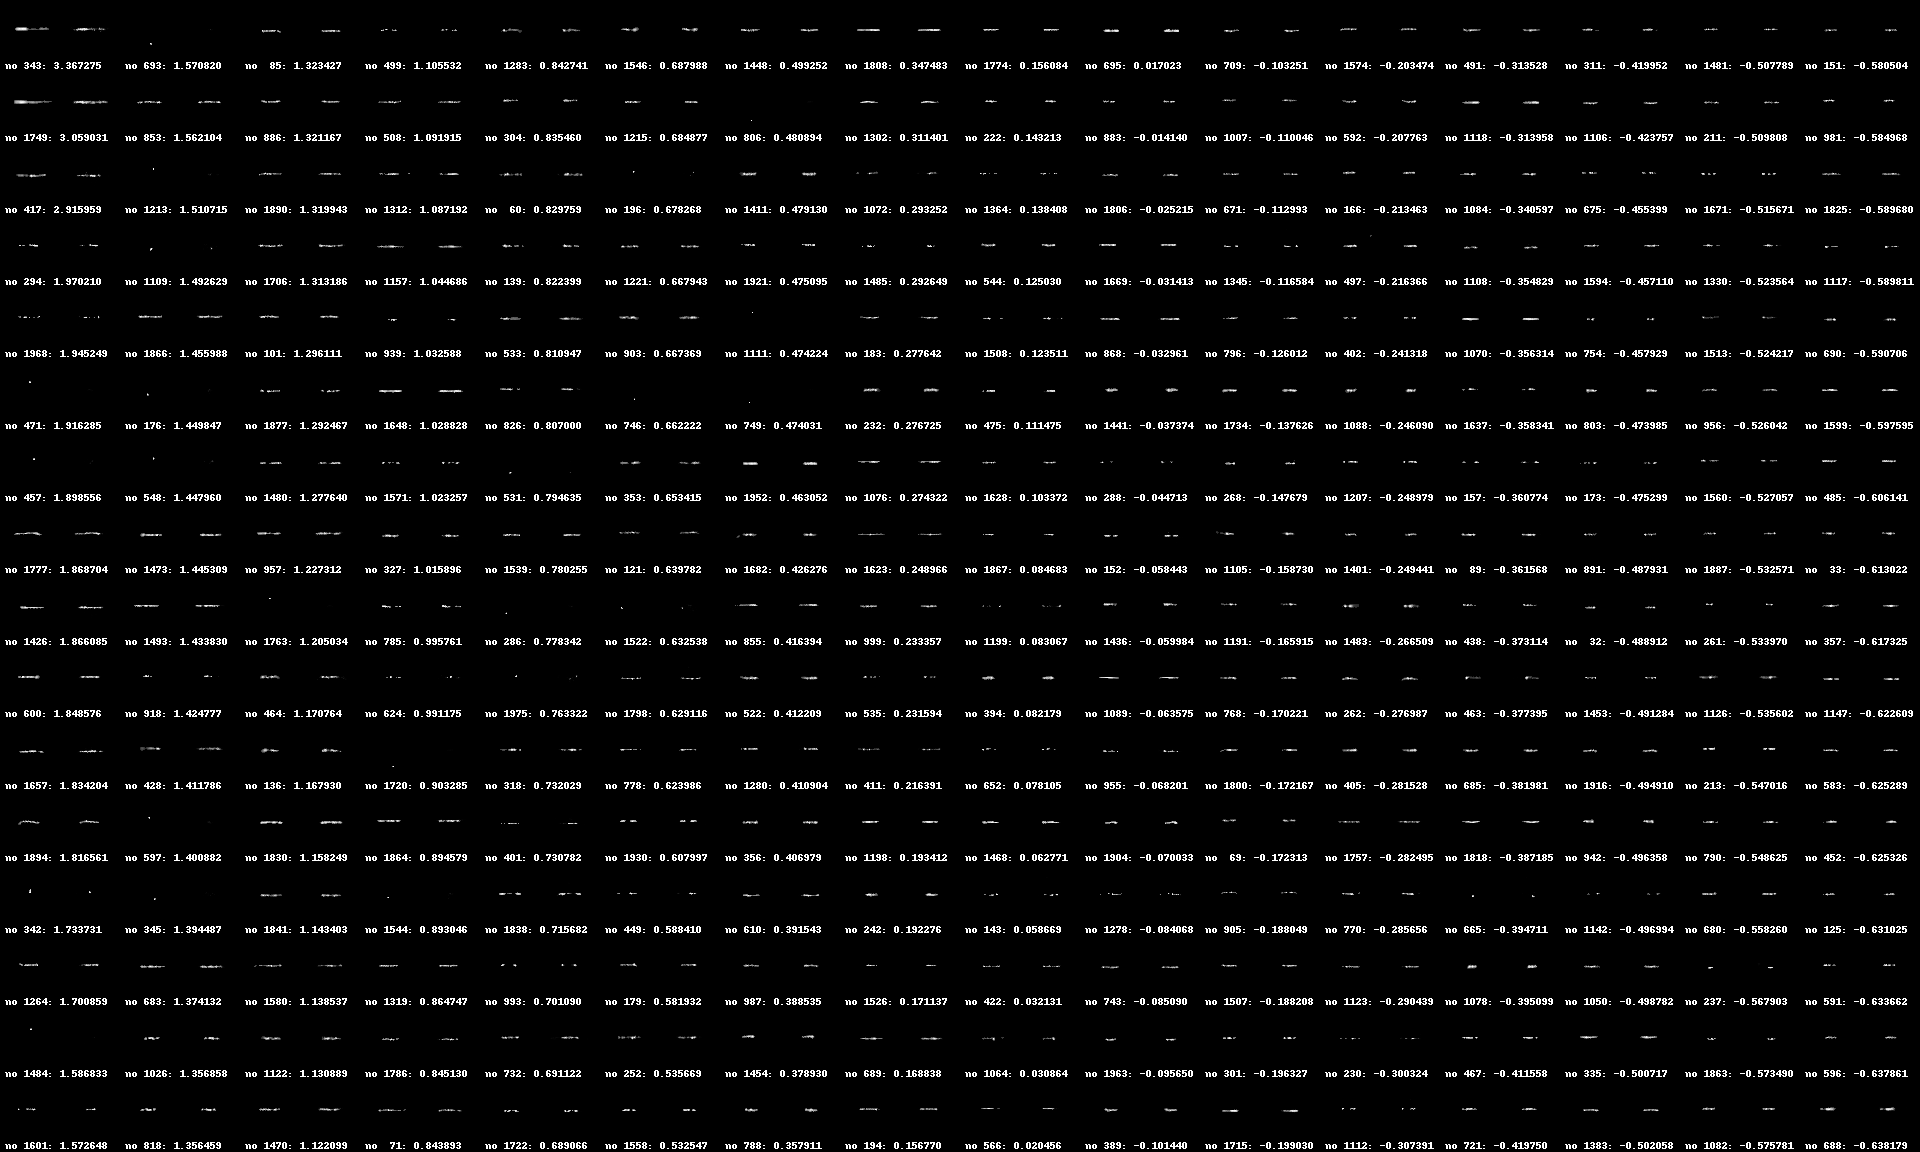

320
0
128
18496
0
256
0
460832
475200
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_48 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 15, 15, 64)        0 

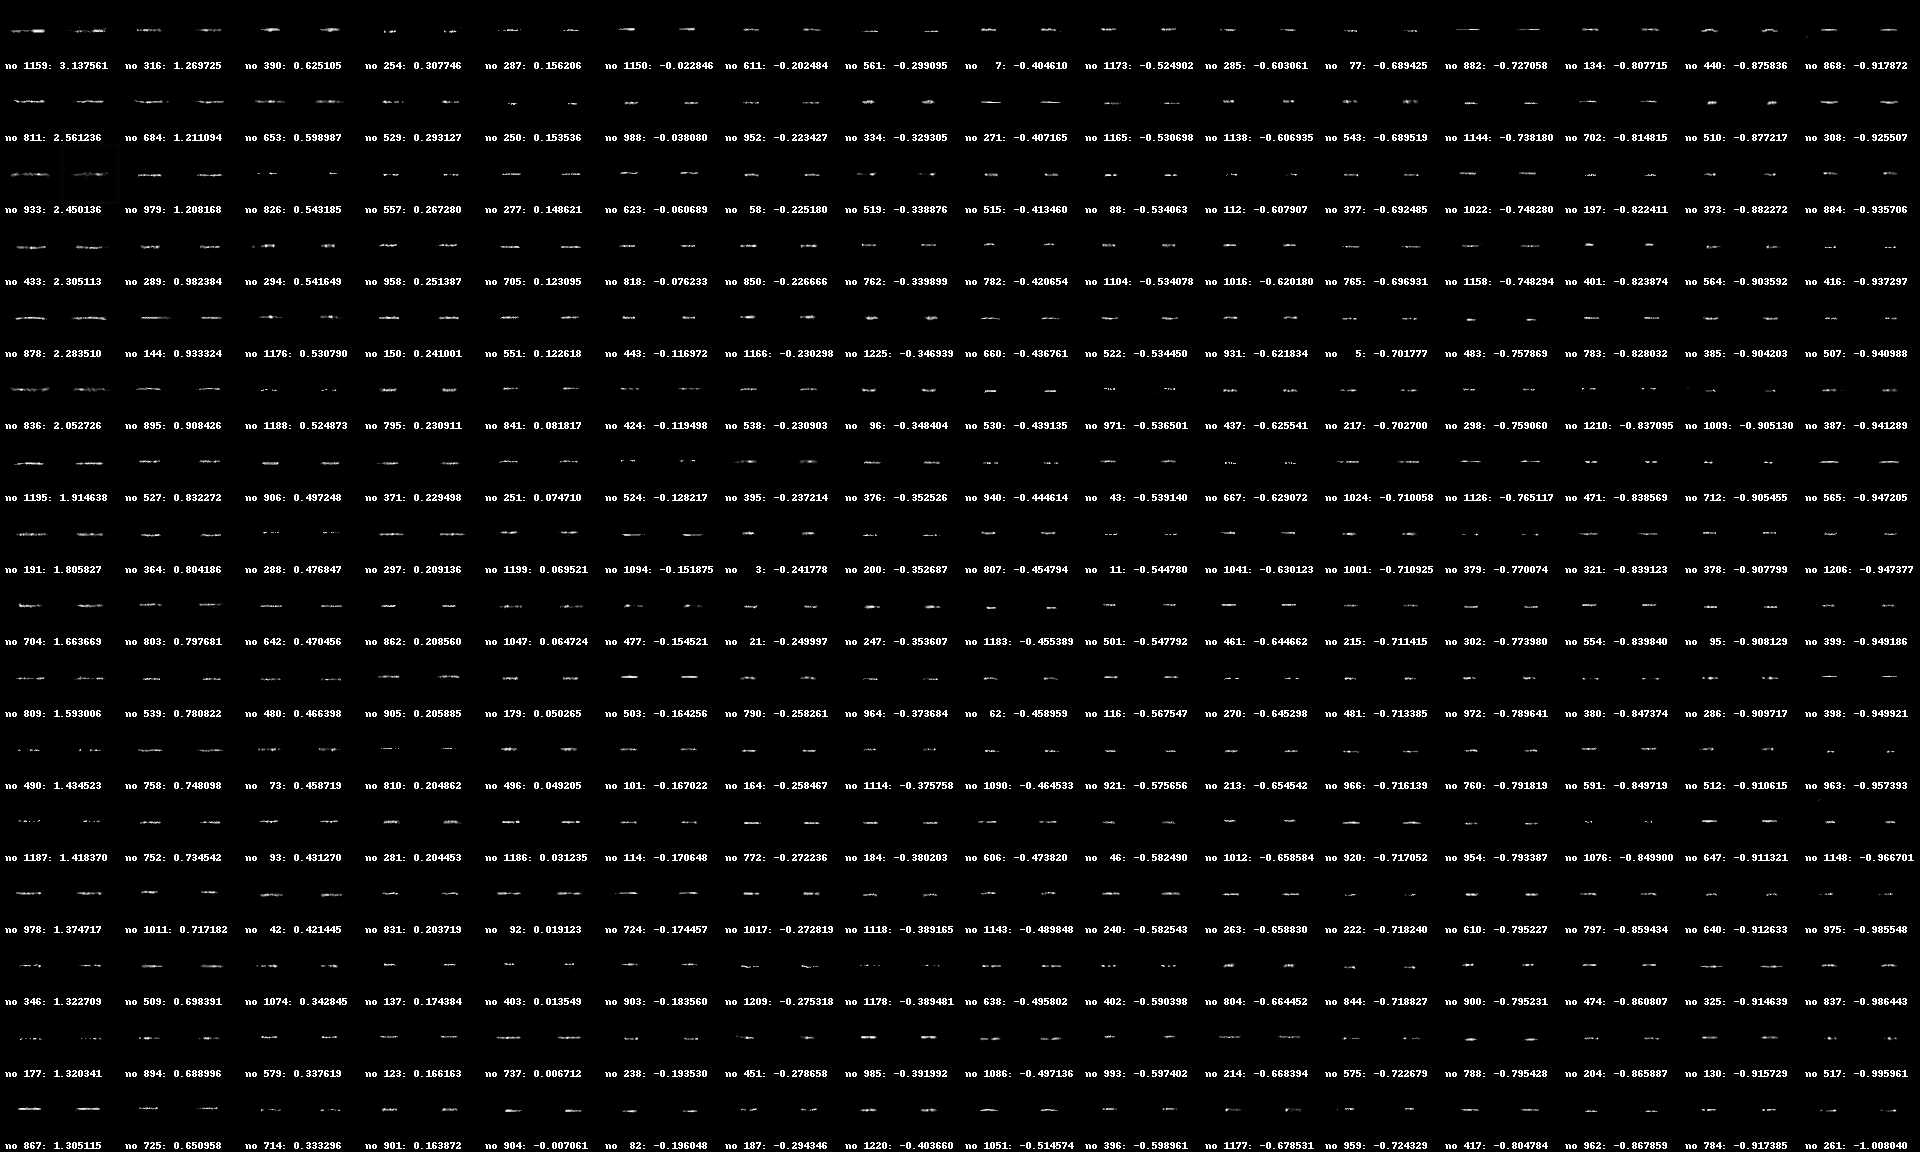

320
0
128
18496
0
256
0
460832
475200
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_52 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_53 (LeakyReLU)  (None, 15, 15, 64)        0 

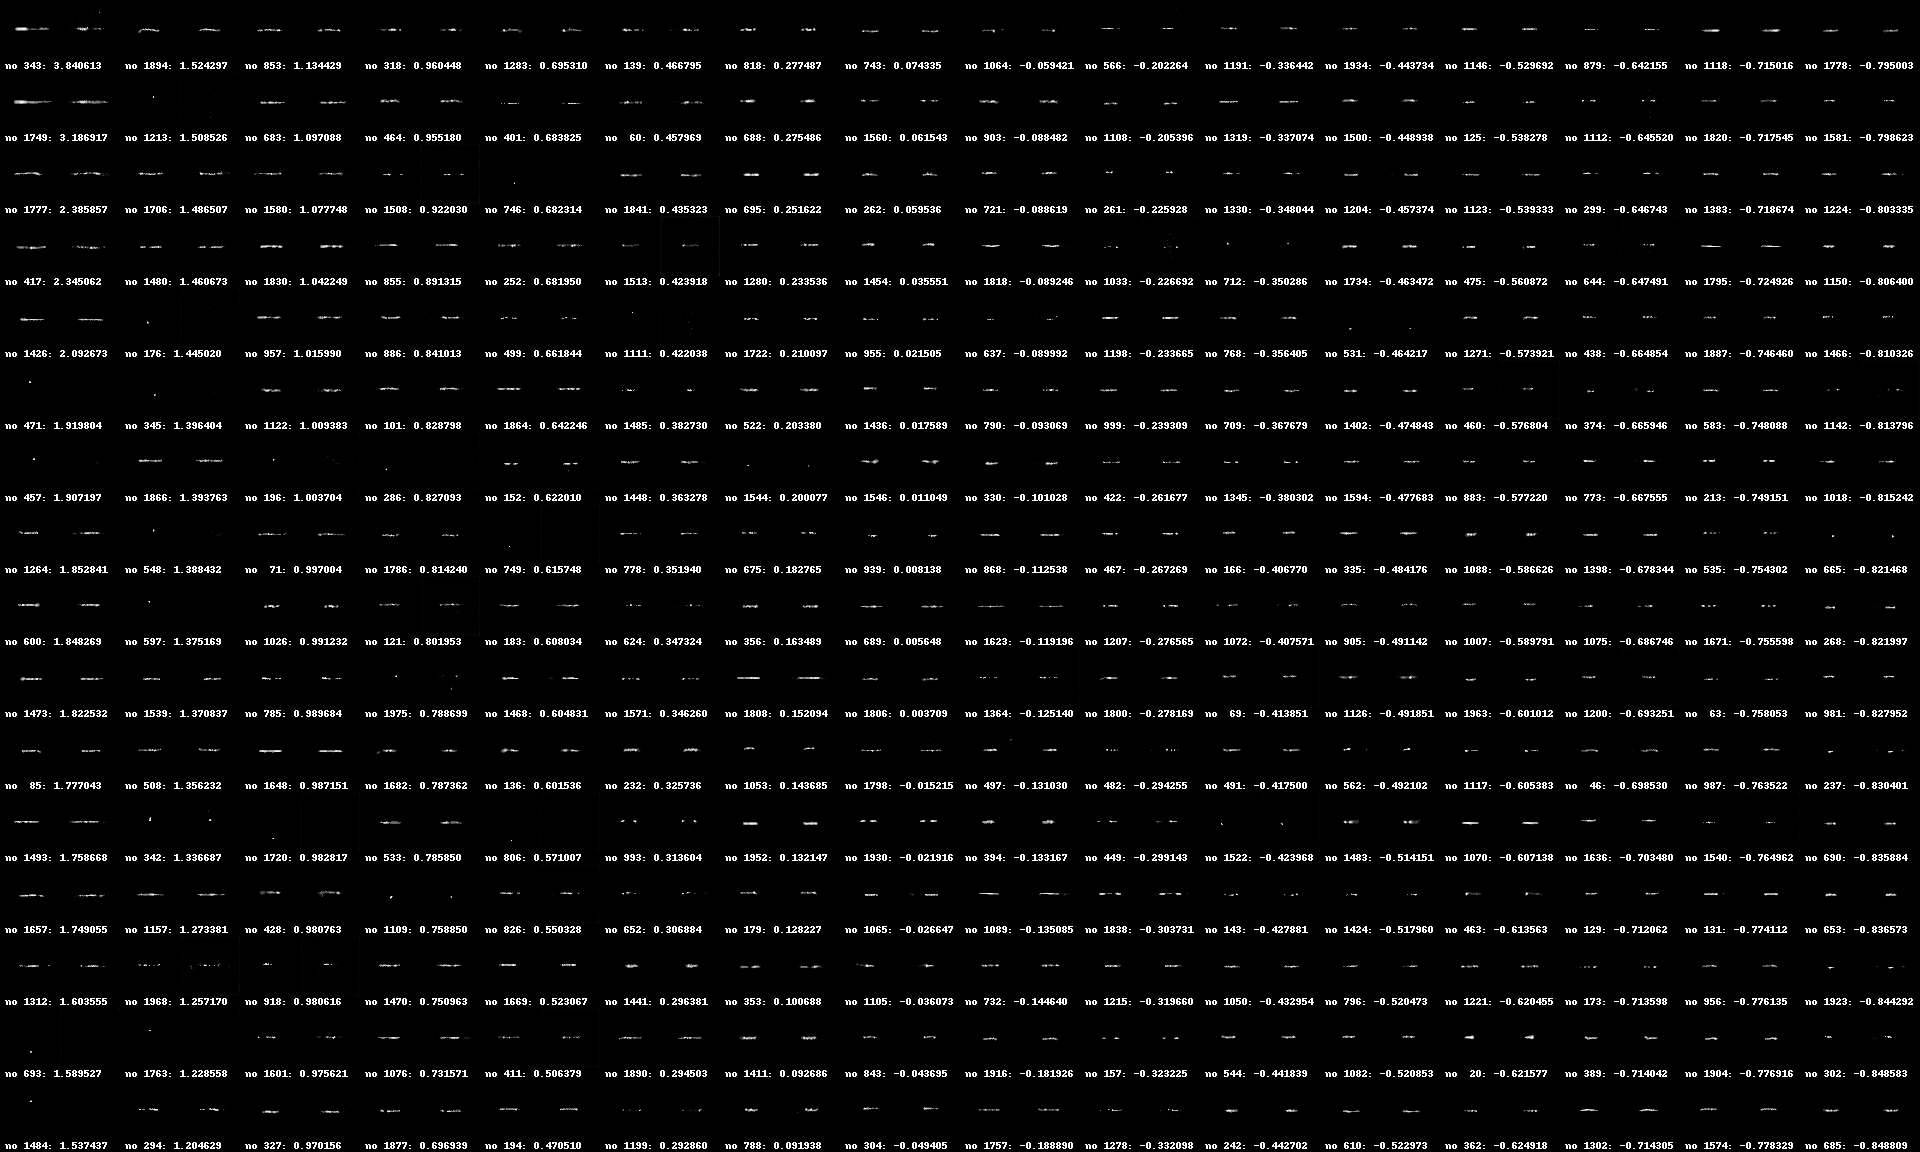

320
0
128
18496
0
256
0
691248
705600
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_56 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 15, 15, 64)        0 

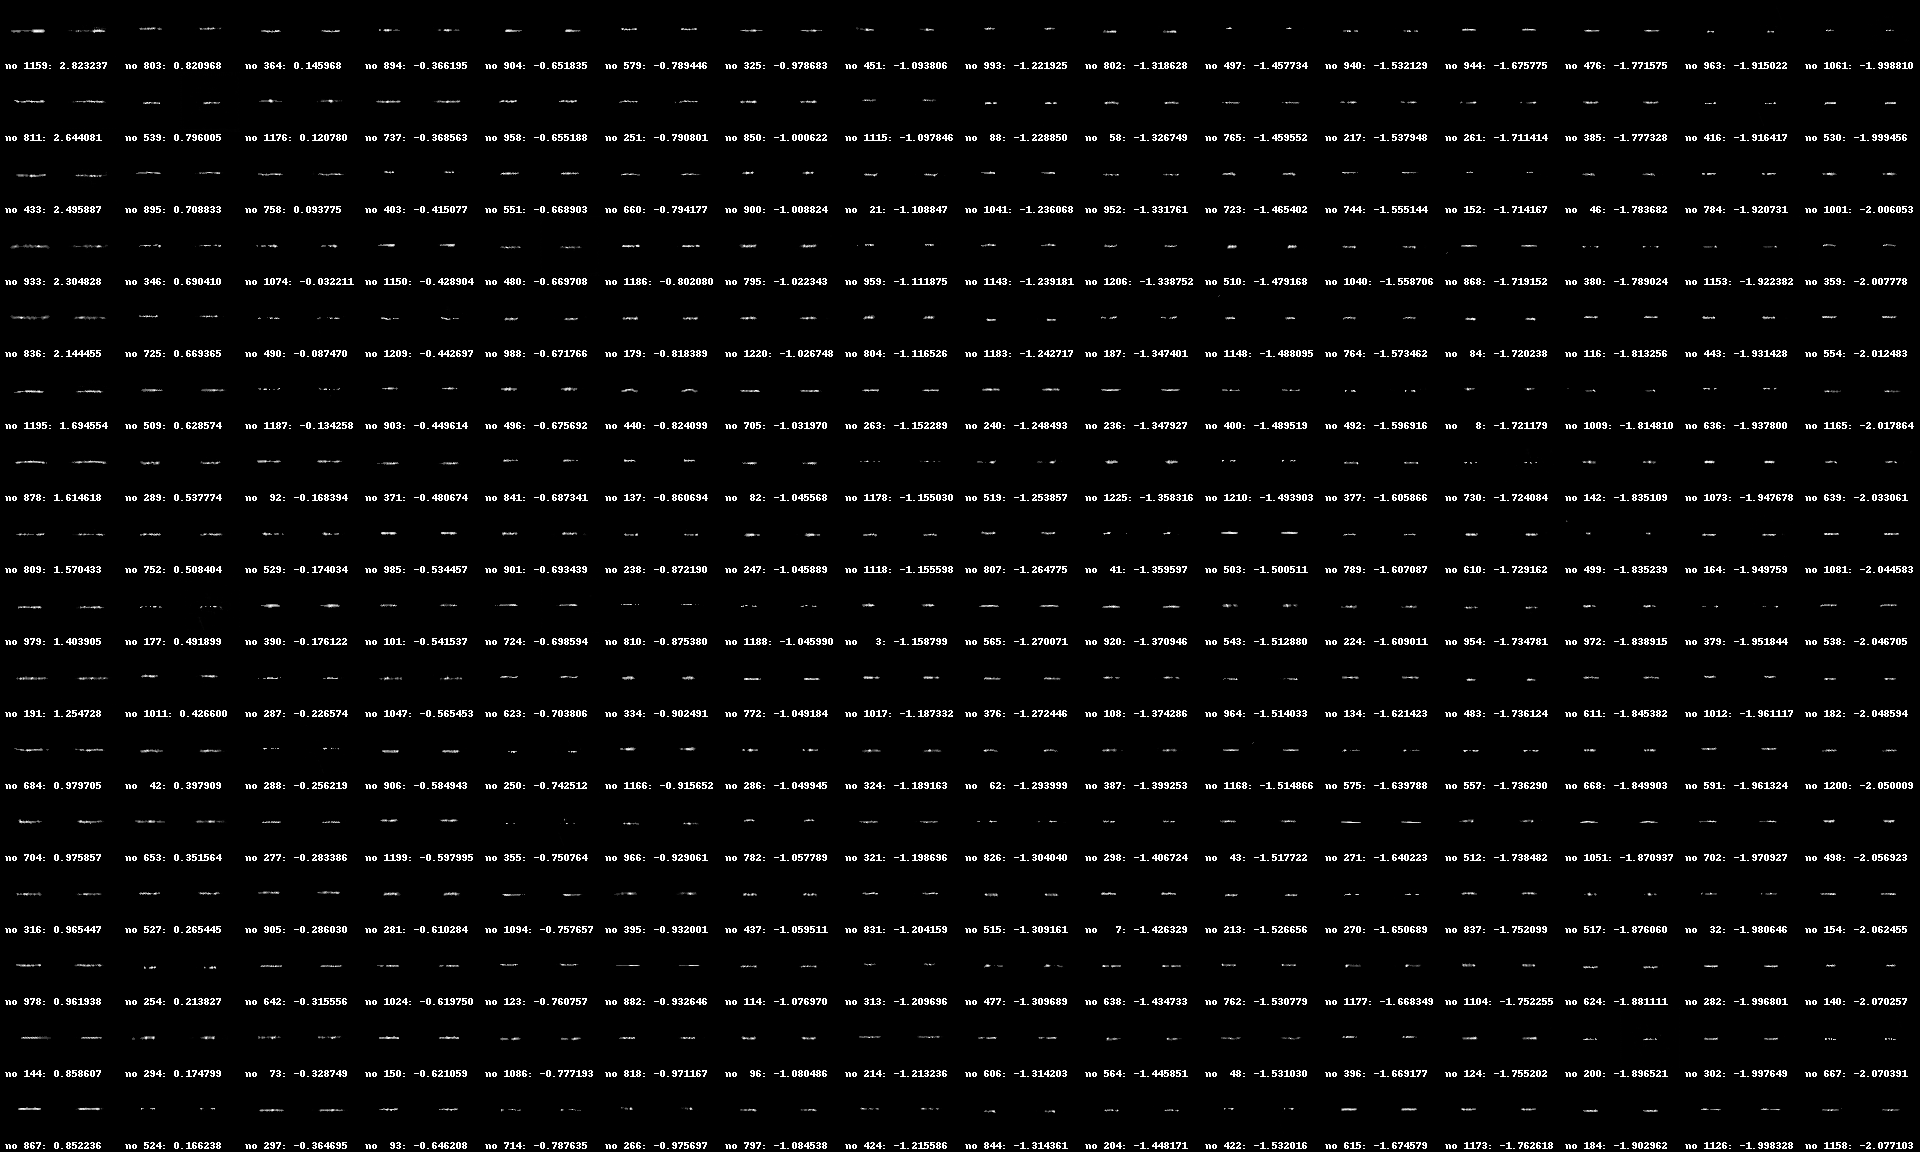

320
0
128
18496
0
256
0
691248
705600
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_60 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 15, 15, 64)        0 

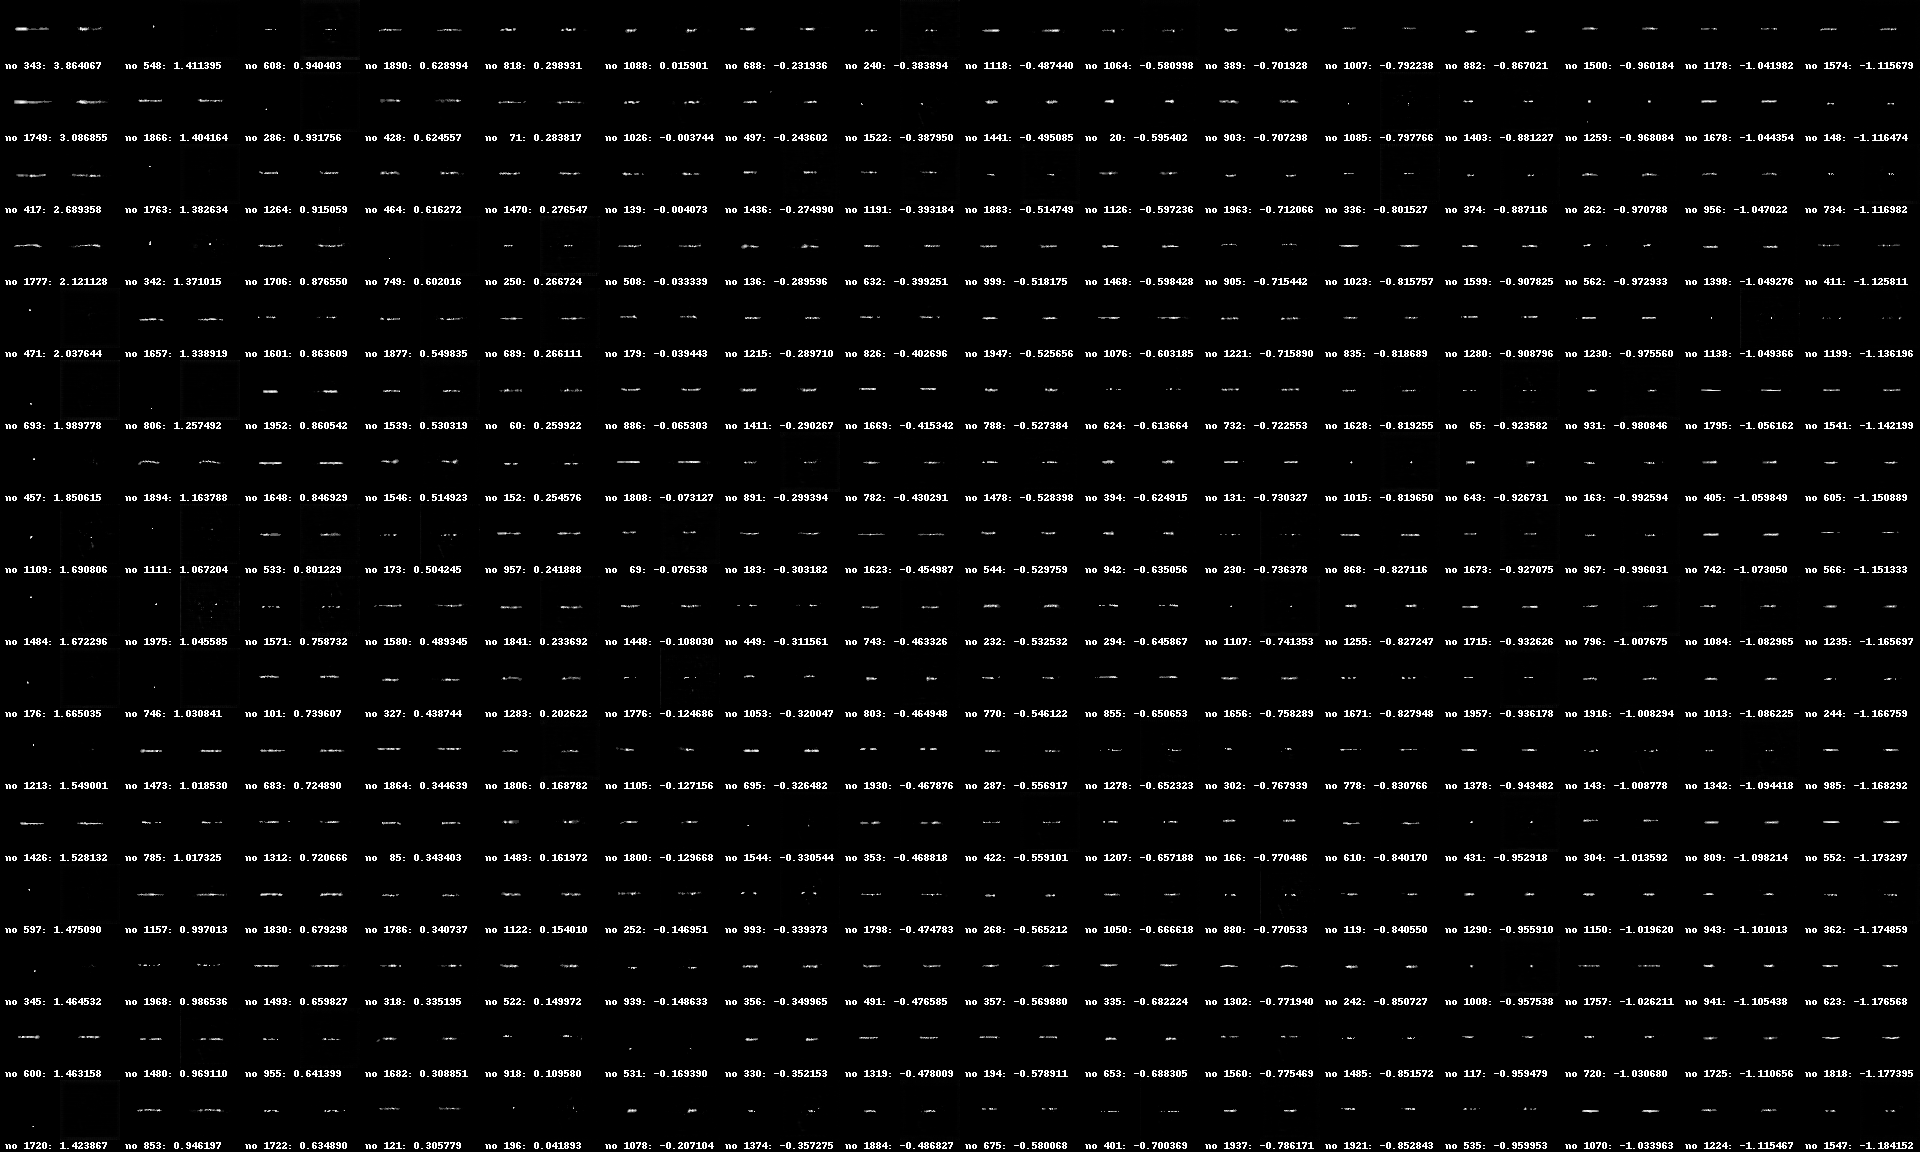

320
0
128
18496
0
256
0
921664
936000
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_64 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_64 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 15, 15, 64)        0 

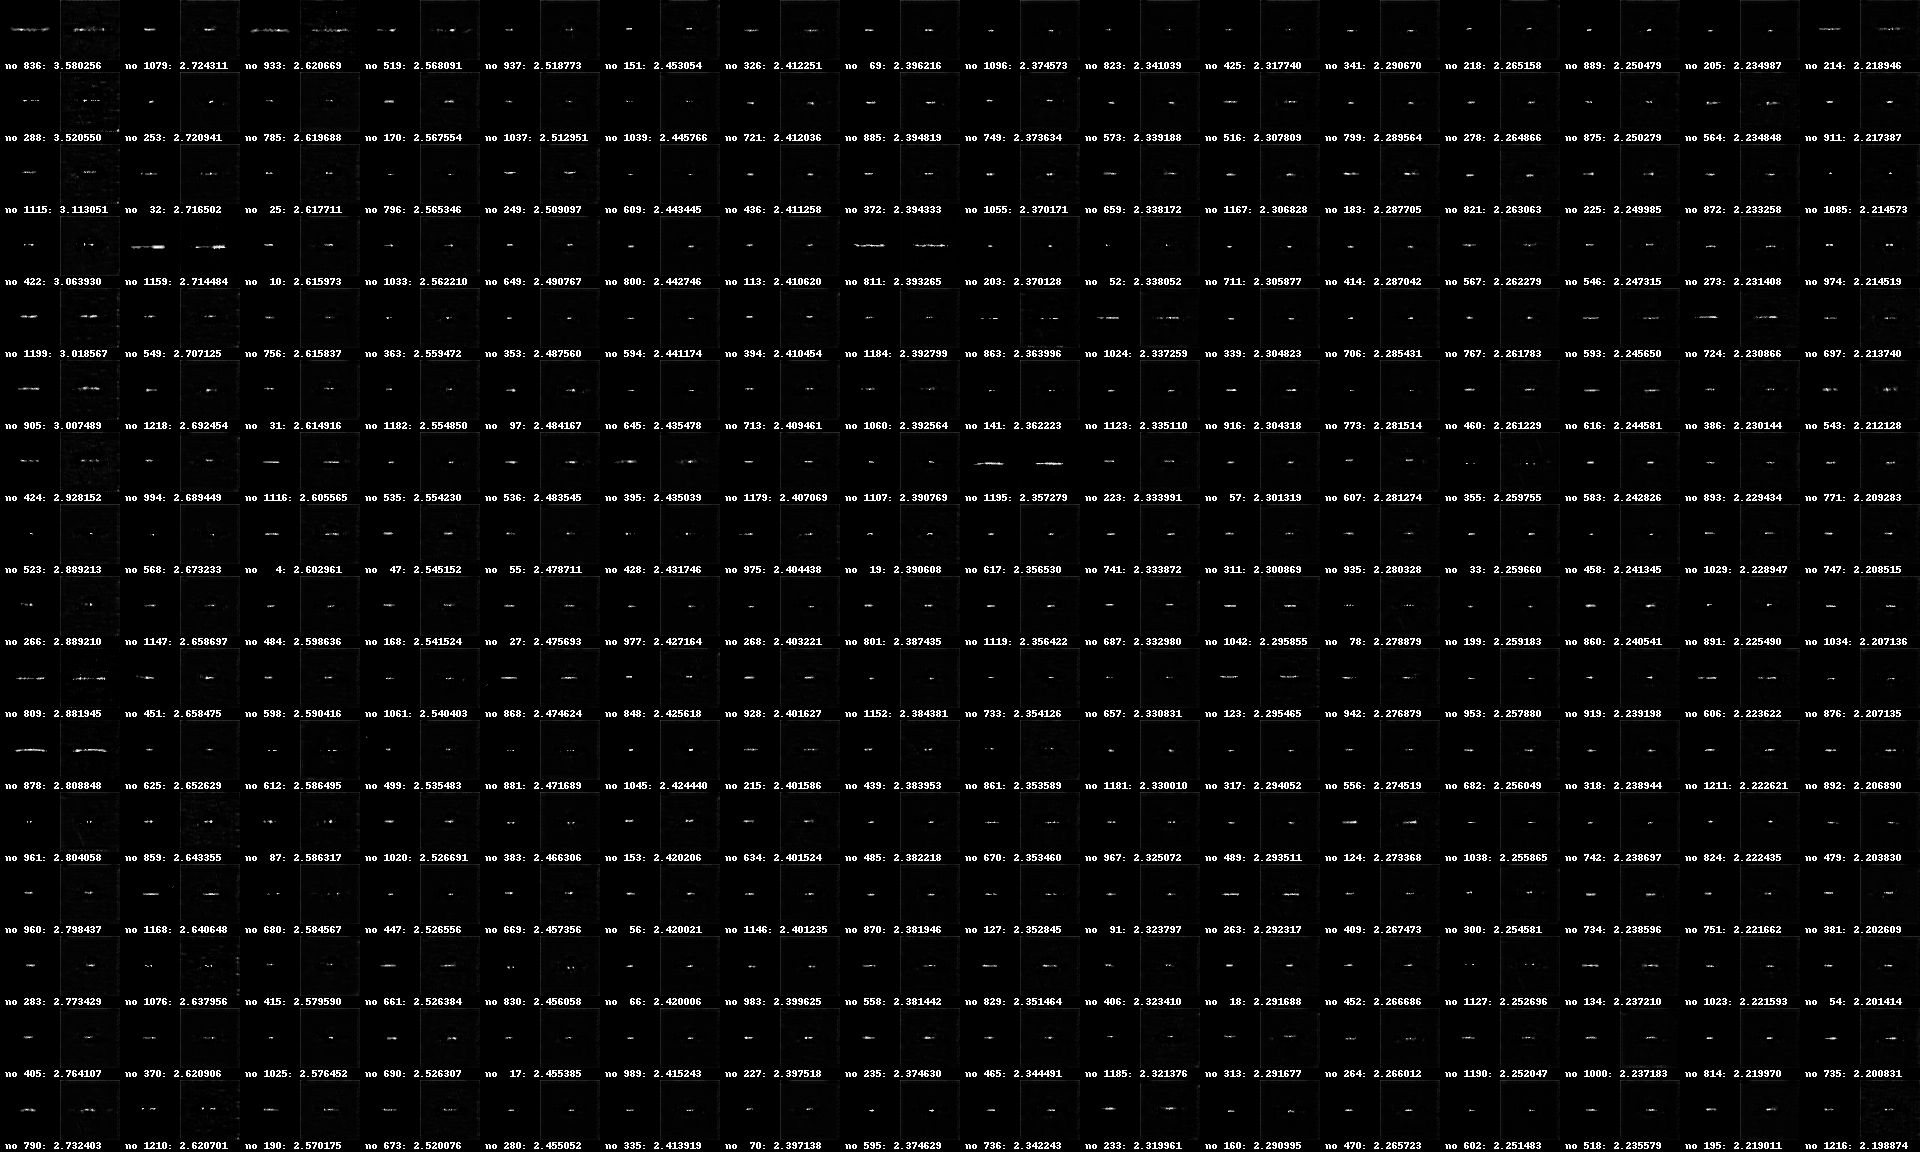

320
0
128
18496
0
256
0
921664
936000
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu_68 (LeakyReLU)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_68 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_35 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 15, 15, 64)        0 

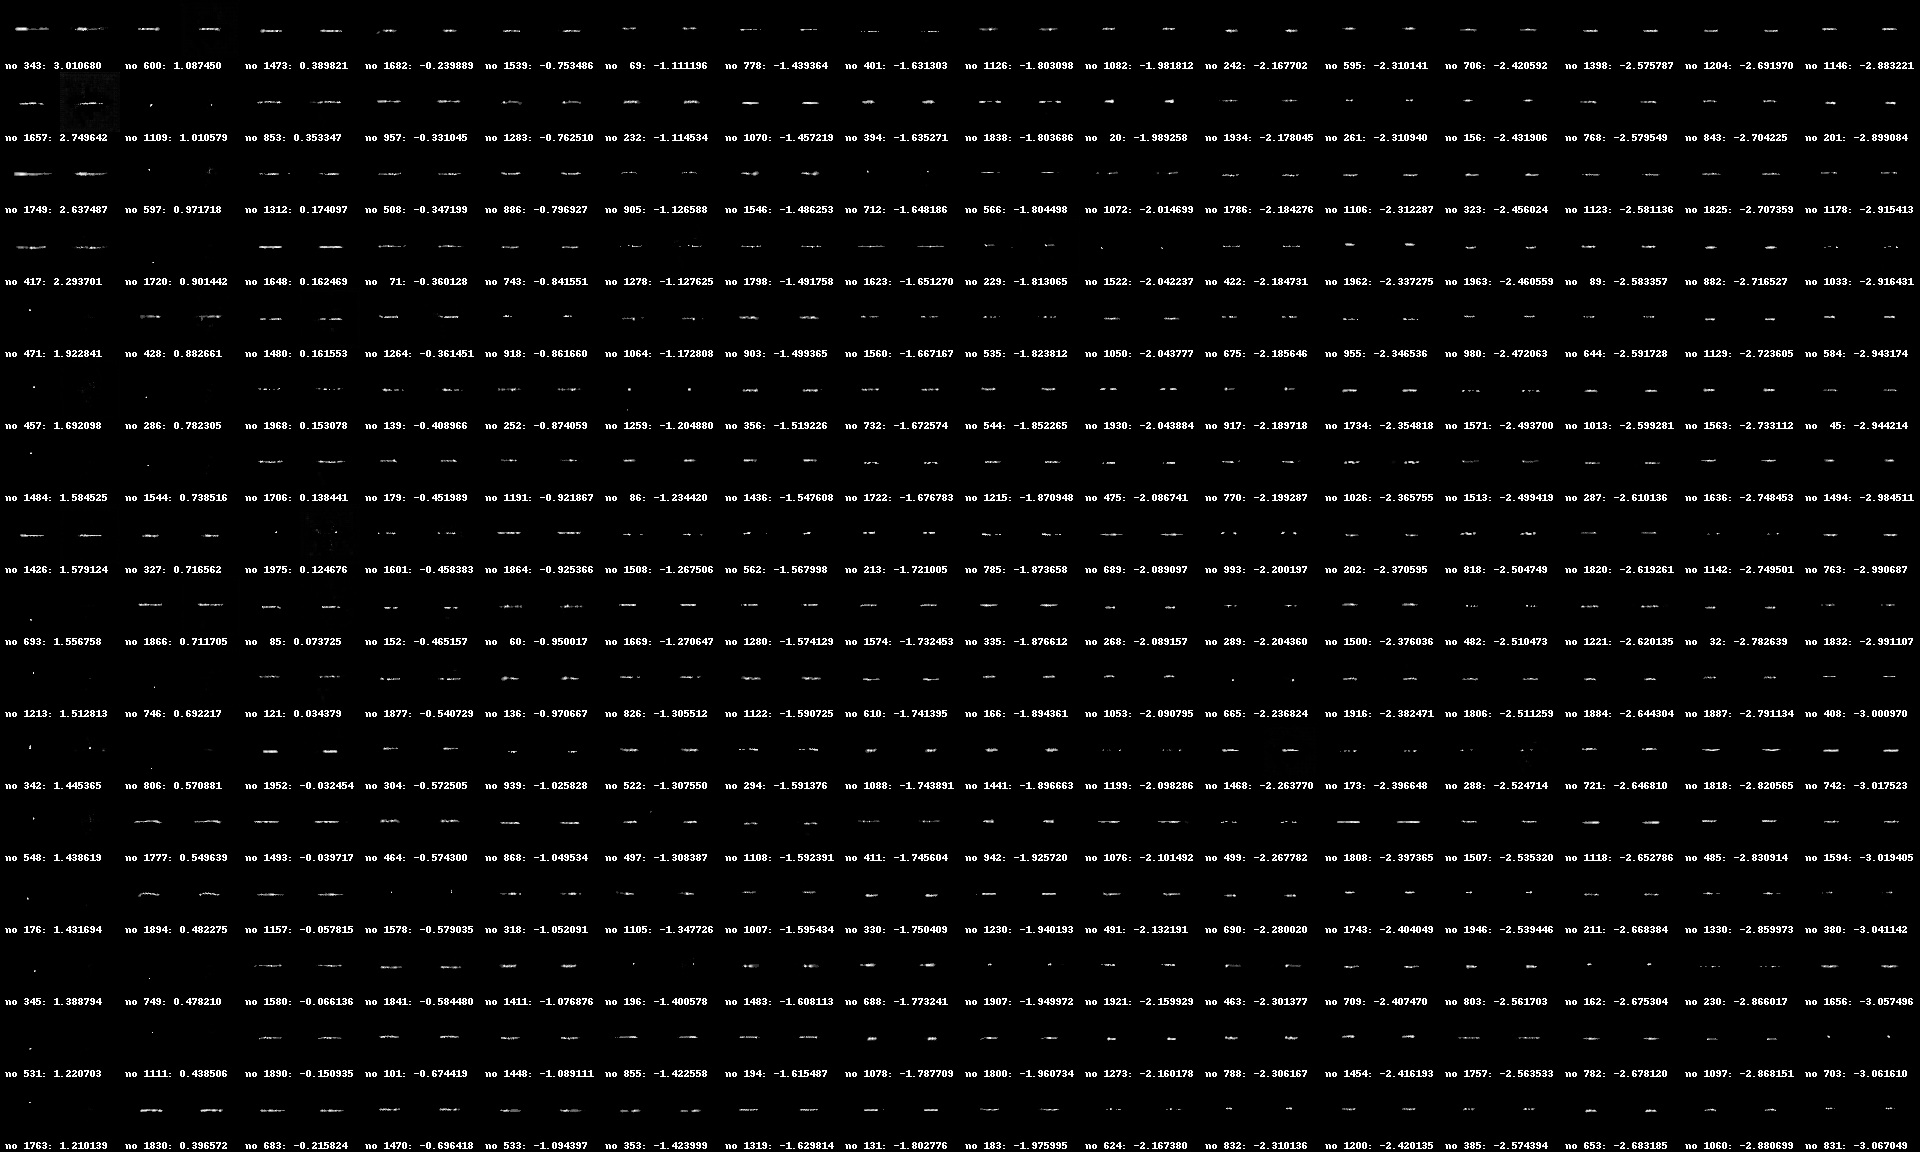

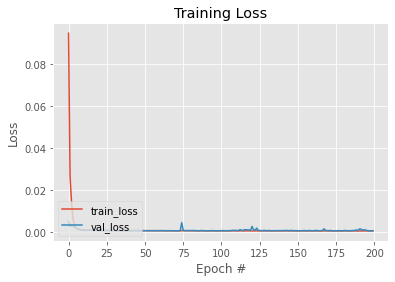

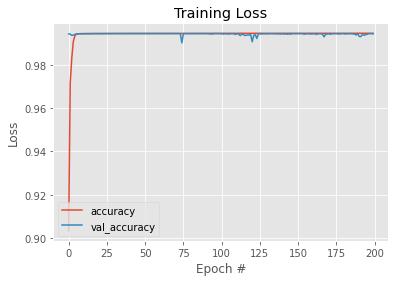

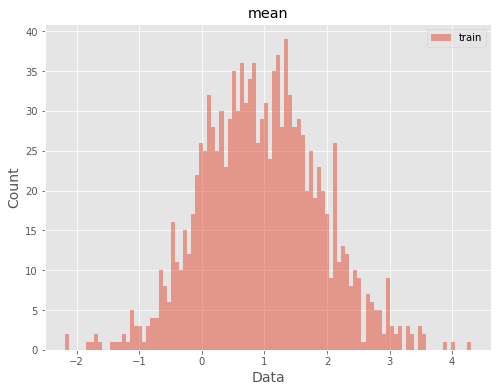

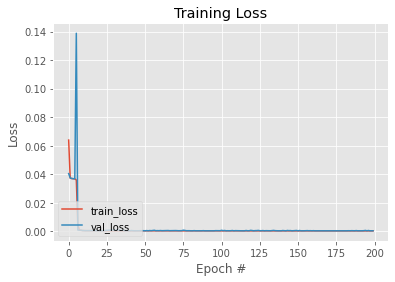

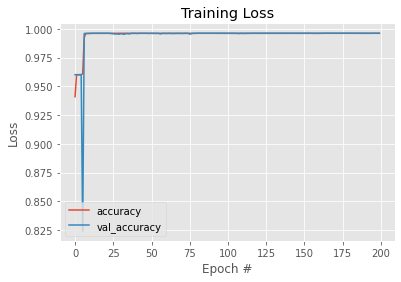

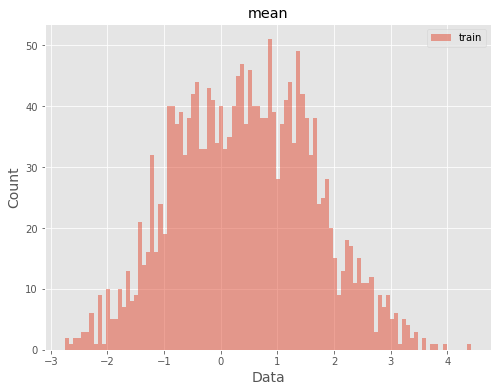

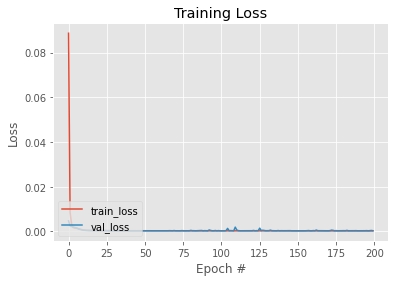

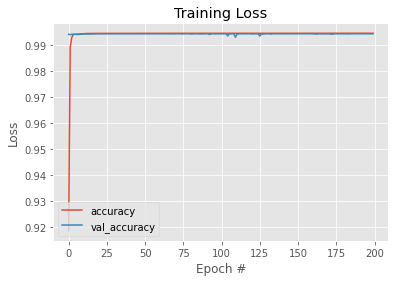

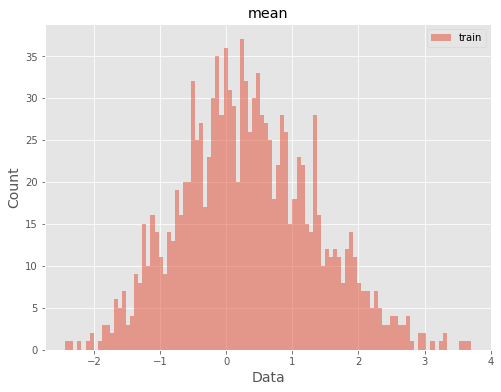

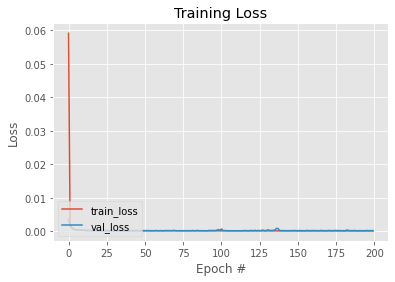

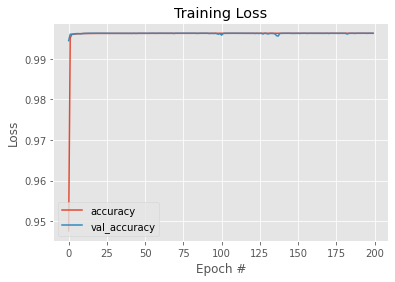

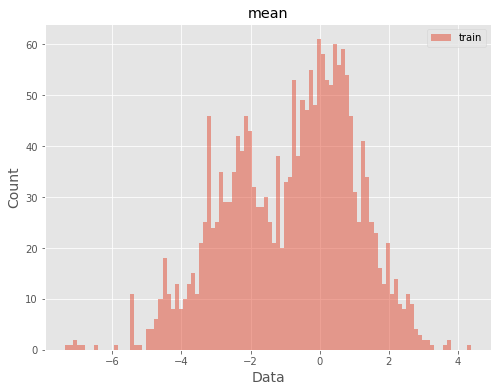

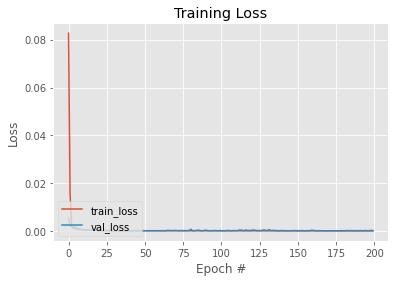

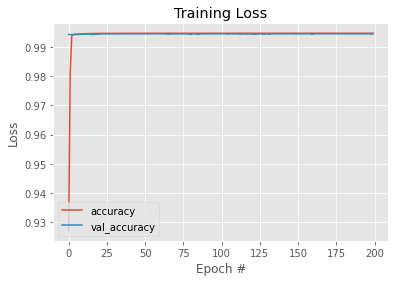

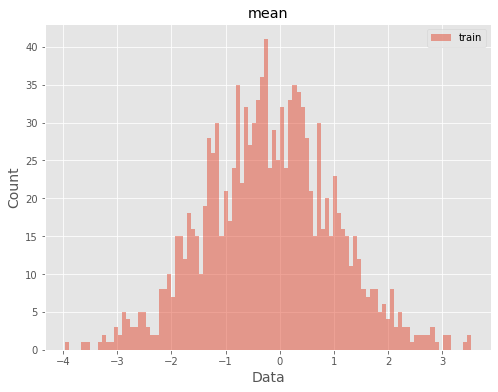

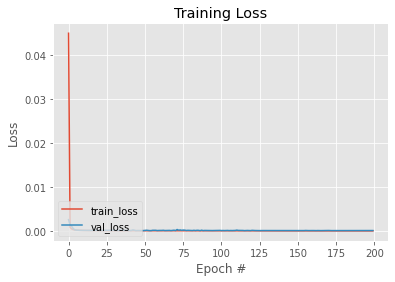

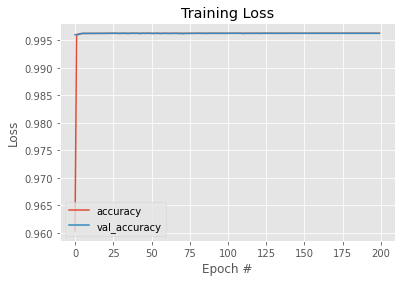

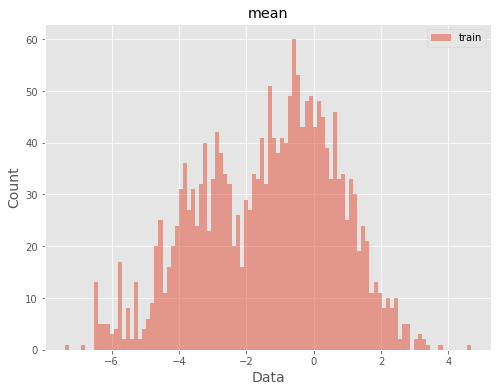

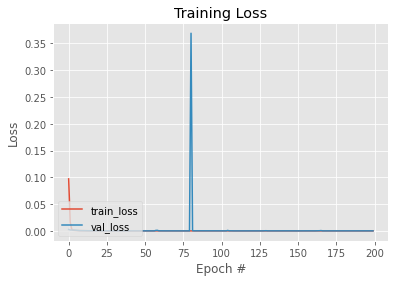

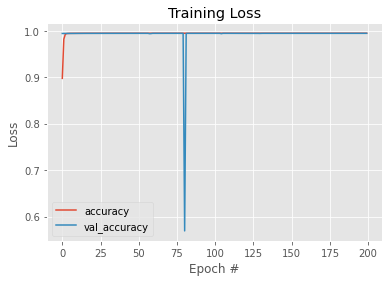

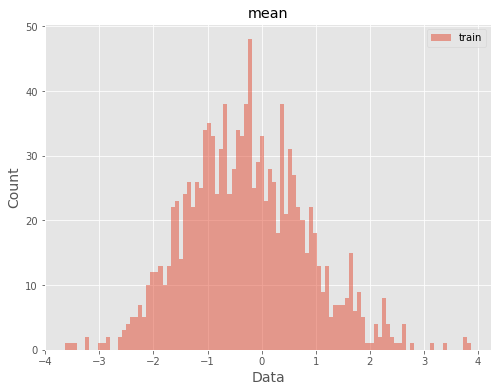

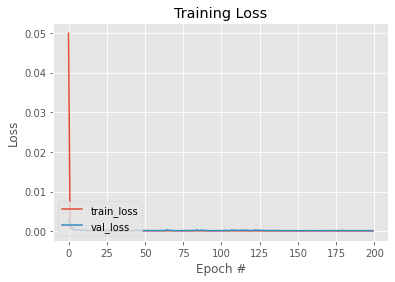

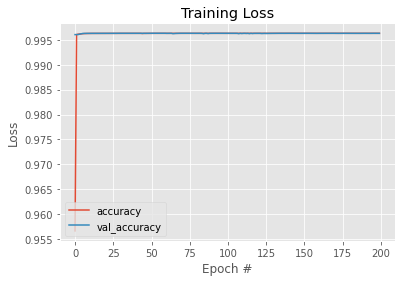

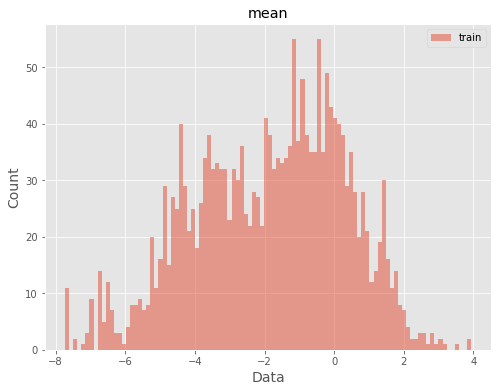

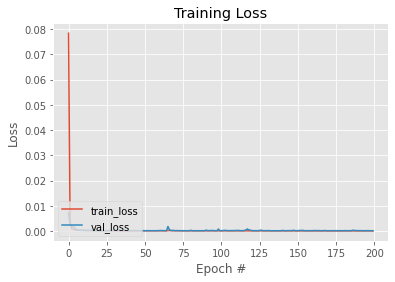

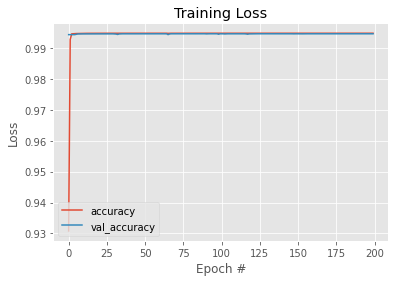

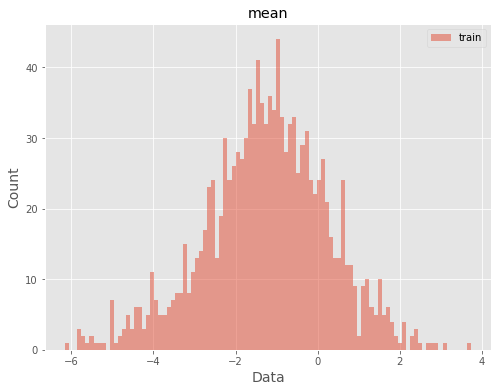

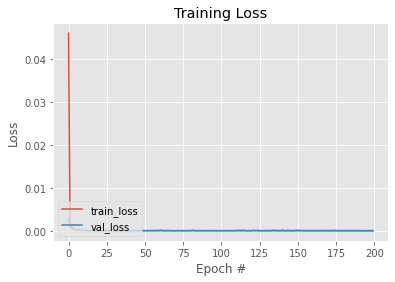

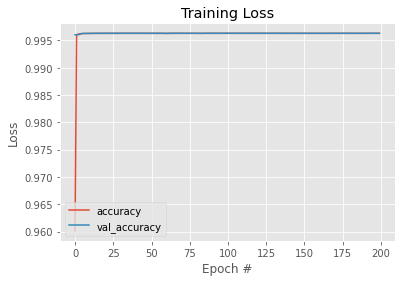

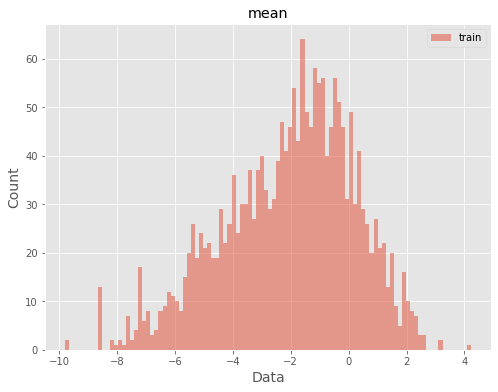

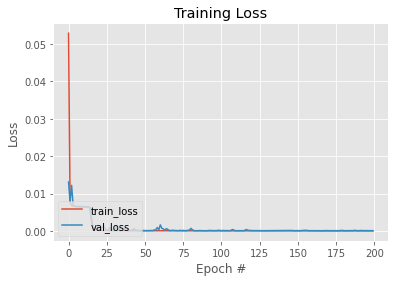

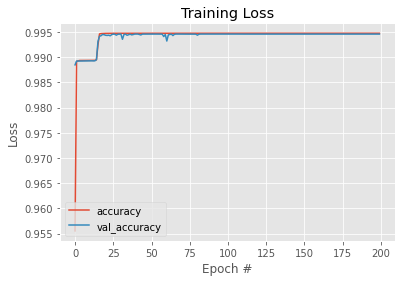

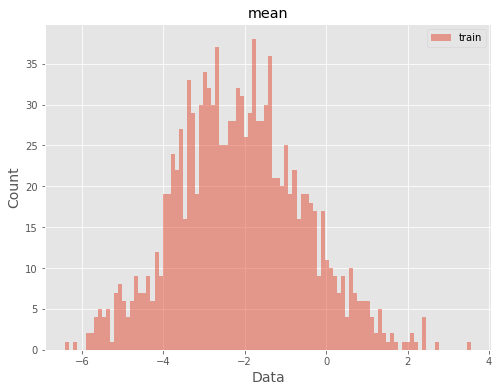

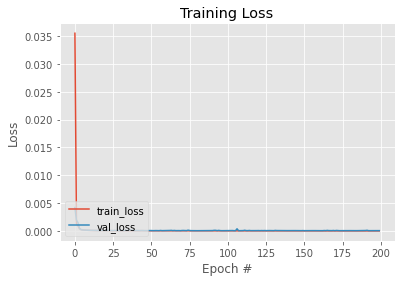

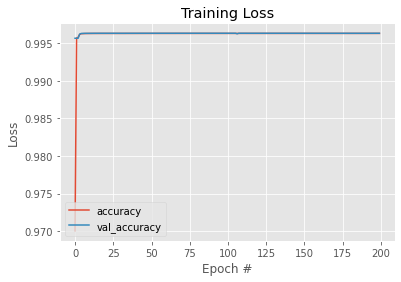

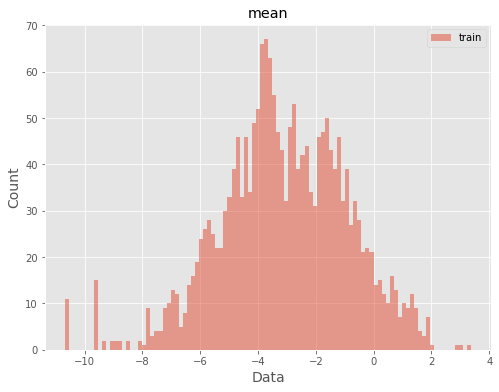

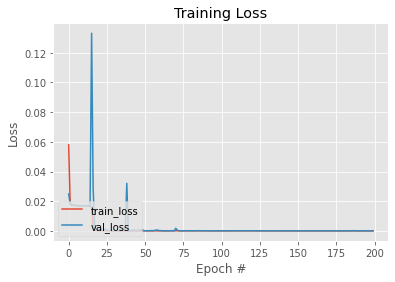

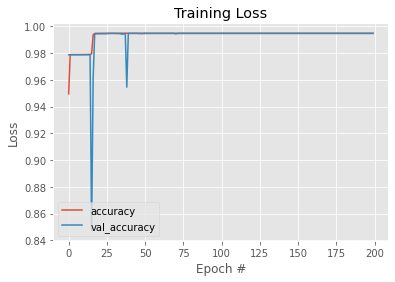

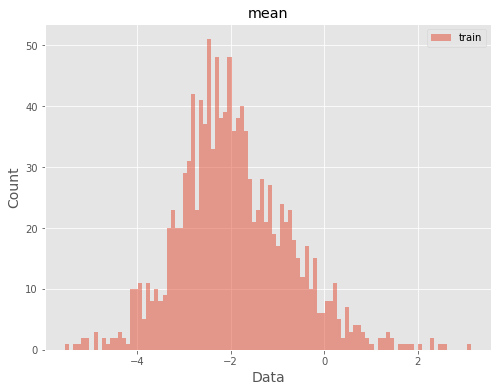

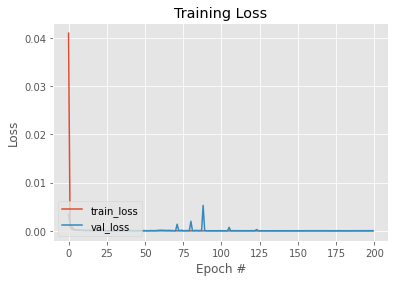

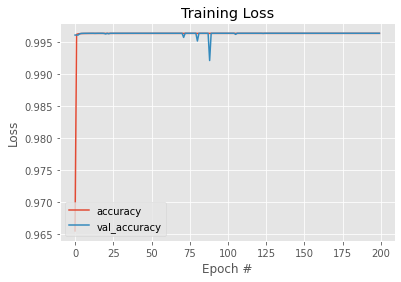

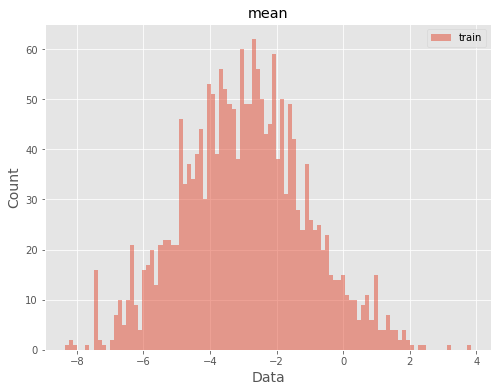

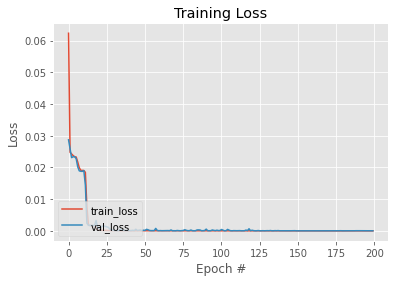

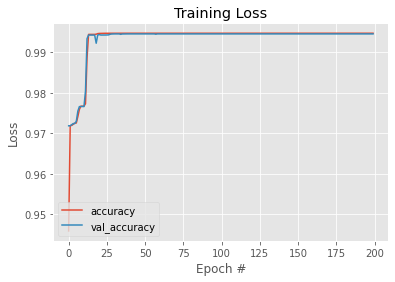

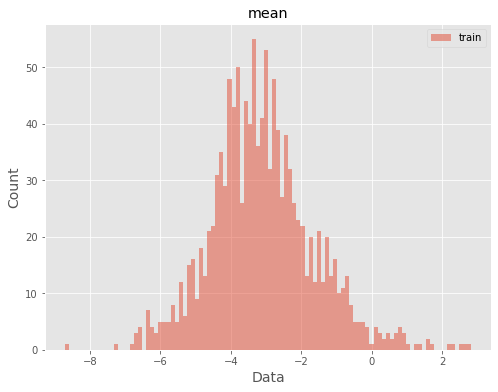

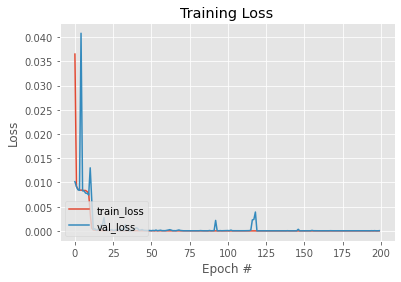

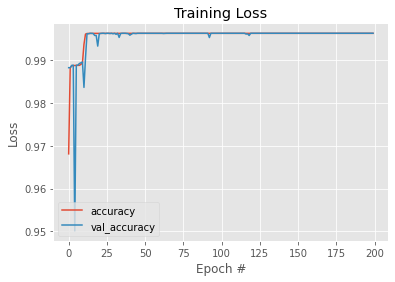

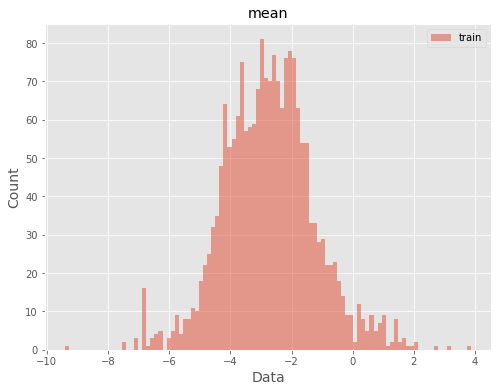

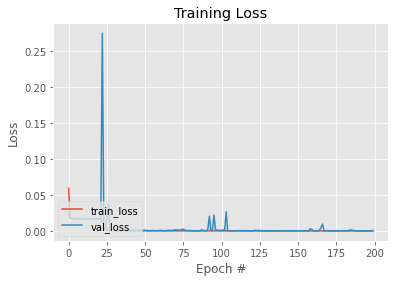

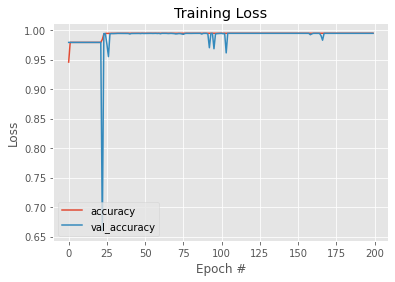

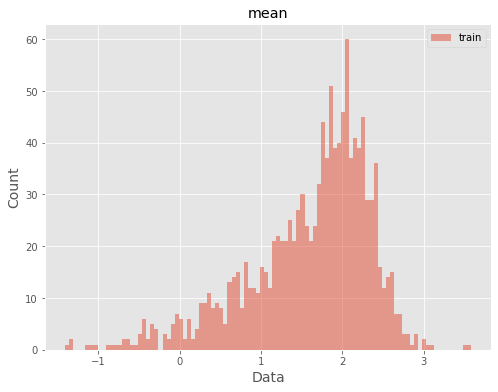

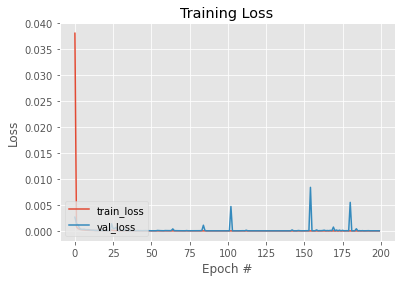

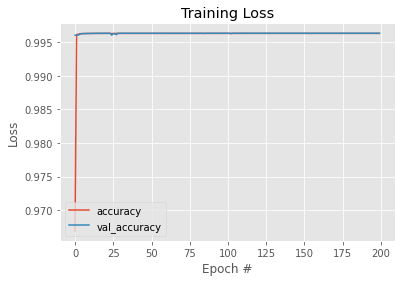

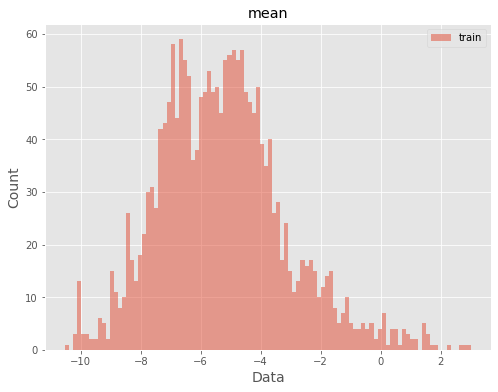

In [7]:
for latentD in [2, 4, 6, 8, 12, 24, 32, 48, 64]:
    train_and_test(tracks2_set[tracks2_train], tracks2_set[tracks2_validate], TRACKS_AC, latentD)
    train_and_test(tnd2_set[tnd2_train], tnd2_set[tnd2_validate], TND_AC, latentD)

In [9]:
# zapis embeddingu do pliku

from keras.models import load_model

def encoder_embedding(model_file, test_set):
    encoder = load_model(model_file.replace('.h5', '-encoder.h5'))
    embedding = encoder.predict(test_set)
    #with_c = np.vstack([v, np.ones(v.shape) * c])
    #transposed = with_c.transpose()
    return embedding

tracks_embedding = encoder_embedding(TRACKS_AC % 16, np.vstack([dots_set, tracks_set, worms_set]))
tracks_embedding_files = np.hstack([dots_files, tracks_files, worms_files])

tnd_embedding = encoder_embedding(TND_AC % 16, np.vstack([dots_set, tracks_set, worms_set]))
tnd_embedding_files = np.hstack([dots_files, tracks_files, worms_files])

np.save("res/emb_array_tracks", tracks_embedding)
np.save("res/emb_array_tnd", tnd_embedding)

with open("res/file_list_tracks.txt", 'w') as fp:
    for ff in tracks_embedding_files:
        fp.write(ff + "\n")

with open("res/file_list_tnd.txt", 'w') as fp:
    for ff in tnd_embedding_files:
        fp.write(ff + "\n")

In [10]:
# kalkulacje kowariancji, mean face i eingenface

def calculate_t(images, fn):
    flip_mat = False

    T = np.zeros((images.shape[1] * images.shape[2], images.shape[0]))
    for i in range(images.shape[0]):
        if i % 1000 == 0:
            print("\tLoading " + str(i) + " of " + str(images.shape[0]))
        #img_help = cv2.imread(files[i], cv2.IMREAD_GRAYSCALE)
        img_help = images[i]
        img_flatten = img_help.flatten('F') # / 255
        T[:,i] = img_flatten

    print('Calculating mean face')
    mean_face = T.mean(axis = 1)

    for i in range(images.shape[0]):
        T[:,i] -= mean_face


    print('Calculating covariance')
    if flip_mat:
        C = np.matmul(T.transpose(), T)
    else:
        C = np.matmul(T, T.transpose())

    C = C / images.shape[0]

    print('Calculating eigenfaces')
    from scipy.linalg import eigh
    w, v = eigh(C)

    if flip_mat:
        v_correct = np.matmul(T, v)
    else:
        v_correct = v

    sort_indices = w.argsort()[::-1]
    w = w[sort_indices]  # puttin the evalues in that order
    v_correct = v_correct[:, sort_indices]


    norms = np.linalg.norm(v_correct, axis=0)# find the norm of each eigenvector
    v_correct = v_correct / norms

    np.save("res/T_st_" + fn, T)
    np.save("res/v_st_" + fn, v_correct)
    np.save("res/w_st_" + fn, w)
    np.save("res/mean_face_st_" + fn, mean_face)
    np.save("res/norms_st_" + fn, norms)

    return [T, v_correct, w, mean_face, norms]

[tracks_T, tracks_v_correct, tracks_w, tracks_mean_face, tracks_norms] = calculate_t(tracks_set, 'tracks')
[tnd_T, tnd_v_correct, tnd_w, tnd_mean_face, tnd_norms] = calculate_t(np.vstack([tracks_set, dots_set]), 'tnd')

	Loading 0 of 3065
	Loading 1000 of 3065
	Loading 2000 of 3065
	Loading 3000 of 3065
Calculating mean face
Calculating covariance
Calculating eigenfaces
	Loading 0 of 4940
	Loading 1000 of 4940
	Loading 2000 of 4940
	Loading 3000 of 4940
	Loading 4000 of 4940
Calculating mean face
Calculating covariance
Calculating eigenfaces


In [14]:
def dbscan(embedding, t_files, latentDim, eps, draw_cluster):
    img_count = embedding.shape[0]
    p = latentDim

    emb_array_copy = np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import DBSCAN

    db = DBSCAN(min_samples=5, eps=eps).fit(emb_array_copy)
    labels = db.labels_
    result = np.where(labels == -1)
    my_ids = result[0]

    #print(labels)
    #print(my_ids)
    print('%f: %d' % (eps, len(my_ids)))

    if draw_cluster:
        import matplotlib.pyplot as plt


        fig = plt.figure(figsize=(32, 32))
        columns = 5
        rows = int(len(my_ids) / 5) + 1

        for aaa in range(len(my_ids)):
            img_help = cv2.imread(t_files[my_ids[aaa]])
            print(t_files[my_ids[aaa]])

            aaa1 = aaa + 1
            r = fig.add_subplot(rows, columns, aaa1)
            r.axis("off")
            plt.imshow(img_help)

        plt.show()
    return len(my_ids)

#dbscan(tnd_embedding, np.hstack([dots_files, tracks_files, worms_files]), 16, 180, True)
for i in range(16):
    dbscan(tnd_embedding, np.hstack([dots_files, tracks_files, worms_files]), 16, eps=(i + 10) * 10, draw_cluster=False)

100.000000: 817
110.000000: 550
120.000000: 396
130.000000: 267
140.000000: 173
150.000000: 114
160.000000: 75
170.000000: 44
180.000000: 27
190.000000: 13
200.000000: 9
210.000000: 7
220.000000: 5
230.000000: 2
240.000000: 1
250.000000: 0


In [31]:
def dbscan_loop(emb_array, w, v, all_files):
    from sklearn.cluster import DBSCAN
    import timeit

    #emb_array = np.load("../pca.res/emb_array_wybrane_3600.npy")
    #w = np.load("../pca.res/w_st_13804.npy")
    #v = np.load("../pca.res/v_st_13804.npy")
    #my_file = open("../pca.res/files.txt", "r")

    #file_content = my_file.read()
    #all_files = file_content.split("\n")

    eig_cumulative = np.copy(w) / np.sum(w)
    for a in range(1,eig_cumulative.shape[0]):
        eig_cumulative[a] += eig_cumulative[a - 1]
    end_coord = []
    a = 0
    while eig_cumulative[a] < 0.75:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.8:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.85:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.9:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.95:
        a = a + 1
    end_coord.append(a)


    for a in range(1, eig_cumulative.shape[0]):
        eig_cumulative[a] += eig_cumulative[a - 1]
    start_coord = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    #start_coord = [10, 20]

    min_samples = [3, 4, 5, 6, 7, 8]
    #eps = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    eps = list((np.asarray(range(30)) + 1) * 10)

    print(sum(w / np.sum(w) * 100))

    #threshold = 1
    #p = 50
    all_files_names = all_files

    output_file = "results_dbscan/clusters"
    output_file_results = "results_dbscan/clusters.txt"
    for my_start_coord in start_coord:
        for my_end_coord in end_coord:
            if my_start_coord < my_end_coord:
                for my_eps in eps:
                    for my_min_samples in min_samples:
                        emb_array_copy = np.copy(emb_array[:, my_start_coord:my_end_coord])
                        ########################################################
                        start = timeit.default_timer()
                        db = DBSCAN(eps=my_eps, min_samples=my_min_samples).fit(emb_array_copy)
                        stop = timeit.default_timer()
                        elapsed_time = stop - start
                        print('Time: ', elapsed_time)

                        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
                        core_samples_mask[db.core_sample_indices_] = True
                        labels = db.labels_

                        # Number of clusters in labels, ignoring noise if present.
                        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                        n_noise_ = list(labels).count(-1)

                        result = np.where(labels == -1)
                        my_ids = result[0]
                        #print(my_ids)
                        output_file_ok = output_file + ",start=" + str(my_start_coord) + ",end=" + str(my_end_coord) \
                                         + ",eps=" + str(my_eps) + ",min_samples=" + str(my_min_samples) + ".txt"
                        print(output_file_ok)

                        with open(output_file_ok, 'w') as fp:
                            for element in my_ids:
                                fp.write(str(element) + "\n")
                        file_object = open(output_file_results, 'a')
                        with open(output_file_results, 'a') as fp:
                            fp.write(str(my_start_coord) + "," + str(my_end_coord) + "," + str(my_eps) + ","
                                          + str(my_min_samples) + "," + str(n_clusters_) + "," + str(len(my_ids)) +
                                     "," + str(elapsed_time) + "\n")

dbscan_loop(tnd_embedding, tracks_w, tracks_v_correct, np.hstack([dots_files, tracks_files, worms_files]))

100.00000000000001
Time:  0.05953040000167675
results_dbscan/clusters,start=0,end=9,eps=10,min_samples=3.txt
Time:  0.05889970000134781
results_dbscan/clusters,start=0,end=9,eps=10,min_samples=4.txt
Time:  0.057480300001770956
results_dbscan/clusters,start=0,end=9,eps=10,min_samples=5.txt
Time:  0.0606316000012157
results_dbscan/clusters,start=0,end=9,eps=10,min_samples=6.txt
Time:  0.05978310000136844
results_dbscan/clusters,start=0,end=9,eps=10,min_samples=7.txt
Time:  0.05574720000004163
results_dbscan/clusters,start=0,end=9,eps=10,min_samples=8.txt
Time:  0.1125945000021602
results_dbscan/clusters,start=0,end=9,eps=20,min_samples=3.txt
Time:  0.1057887999995728
results_dbscan/clusters,start=0,end=9,eps=20,min_samples=4.txt
Time:  0.10923950000142213
results_dbscan/clusters,start=0,end=9,eps=20,min_samples=5.txt
Time:  0.10188530000232277
results_dbscan/clusters,start=0,end=9,eps=20,min_samples=6.txt
Time:  0.10063299999819719
results_dbscan/clusters,start=0,end=9,eps=20,min_samples

In [15]:
def optics(embedding, t_files, latentDim, eps, draw_cluster):
    img_count = embedding.shape[0]
    p = latentDim

    emb_array_copy = np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import OPTICS

    db = OPTICS(min_samples=5, cluster_method='dbscan', eps=eps).fit(emb_array_copy)
    labels = db.labels_
    result = np.where(labels == -1)
    my_ids = result[0]

    #print(labels)
    #print(my_ids)
    print('%f: %d' % (eps, len(my_ids)))

    if draw_cluster:
        import matplotlib.pyplot as plt


        fig = plt.figure(figsize=(32, 32))
        columns = 5
        rows = int(len(my_ids) / 5) + 1

        for aaa in range(len(my_ids)):
            img_help = cv2.imread(t_files[my_ids[aaa]])
            print(t_files[my_ids[aaa]])

            aaa1 = aaa + 1
            r = fig.add_subplot(rows, columns, aaa1)
            r.axis("off")
            plt.imshow(img_help)

        plt.show()
    return len(my_ids)

#dbscan(tnd_embedding, np.hstack([dots_files, tracks_files, worms_files]), 16, 180, True)
for i in range(16):
    optics(tnd_embedding, np.hstack([dots_files, tracks_files, worms_files]), 16, eps=(i + 10) * 10, draw_cluster=False)

100.000000: 817
110.000000: 550
120.000000: 396
130.000000: 268
140.000000: 173
150.000000: 114
160.000000: 75
170.000000: 44
180.000000: 27
190.000000: 13
200.000000: 9
210.000000: 7
220.000000: 5
230.000000: 2
240.000000: 1
250.000000: 0


In [21]:
def optics_loop(emb_array, w, v, all_files):
    from sklearn.cluster import OPTICS
    import timeit

    eig_cumulative = np.copy(w) / np.sum(w)
    for a in range(1,eig_cumulative.shape[0]):
        eig_cumulative[a] += eig_cumulative[a - 1]
    end_coord = []
    a = 0
    while eig_cumulative[a] < 0.75:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.8:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.85:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.9:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.95:
        a = a + 1
    end_coord.append(a)


    for a in range(1, eig_cumulative.shape[0]):
        eig_cumulative[a] += eig_cumulative[a - 1]
    start_coord = [0, 1, 2, 3, 4, 5]
    #start_coord = [10, 20]

    min_samples = [3, 4, 5, 6, 7, 8]
    #eps = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    eps = list((np.asarray(range(16)) + 10) * 10)


    print(sum(w / np.sum(w) * 100))

    #threshold = 1
    #p = 50
    all_files_names = all_files

    output_file = "results_OPTICS/clusters"
    output_file_results = "results_OPTICS/clusters.txt"
    for my_start_coord in start_coord:
        for my_end_coord in end_coord:
            if my_start_coord < my_end_coord:
                for my_eps in eps:
                    for my_min_samples in min_samples:
                        emb_array_copy = np.copy(emb_array[:, my_start_coord:my_end_coord])
                        ########################################################
                        start = timeit.default_timer()
                        #db = DBSCAN(eps=my_eps, min_samples=my_min_samples).fit(emb_array_copy)
                        db = OPTICS(min_samples=my_min_samples, cluster_method='dbscan', eps=my_eps).fit(emb_array_copy)

                        stop = timeit.default_timer()
                        elapsed_time = stop - start
                        print('Time: ', elapsed_time)

                        #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
                        #core_samples_mask[db.core_sample_indices_] = True
                        labels = db.labels_

                        # Number of clusters in labels, ignoring noise if present.
                        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                        n_noise_ = list(labels).count(-1)

                        result = np.where(labels == -1)
                        my_ids = result[0]
                        #print(my_ids)
                        output_file_ok = output_file + ",start=" + str(my_start_coord) + ",end=" + str(my_end_coord) \
                                         + ",eps=" + str(my_eps) + ",min_samples=" + str(my_min_samples) + ".txt"
                        print(output_file_ok)

                        with open(output_file_ok, 'w') as fp:
                            for element in my_ids:
                                fp.write(str(element) + "\n")
                        file_object = open(output_file_results, 'a')
                        with open(output_file_results, 'a') as fp:
                            fp.write(str(my_start_coord) + "," + str(my_end_coord) + "," + str(my_eps) + ","
                                          + str(my_min_samples) + "," + str(n_clusters_) + "," + str(len(my_ids)) +
                                     "," + str(elapsed_time) + "\n")

optics_loop(tnd_embedding, tracks_w, tracks_v_correct, np.hstack([dots_files, tracks_files, worms_files]))

100.00000000000001
Time:  3.160455400000501
results_OPTICS/clusters,start=0,end=9,eps=100,min_samples=3.txt
Time:  2.397702300000674
results_OPTICS/clusters,start=0,end=9,eps=100,min_samples=4.txt
Time:  2.5664701999994577
results_OPTICS/clusters,start=0,end=9,eps=100,min_samples=5.txt
Time:  3.2877879999978177
results_OPTICS/clusters,start=0,end=9,eps=100,min_samples=6.txt
Time:  2.597449000000779
results_OPTICS/clusters,start=0,end=9,eps=100,min_samples=7.txt
Time:  2.6592248999986623
results_OPTICS/clusters,start=0,end=9,eps=100,min_samples=8.txt
Time:  2.660063600000285
results_OPTICS/clusters,start=0,end=9,eps=110,min_samples=3.txt
Time:  2.675822999997763
results_OPTICS/clusters,start=0,end=9,eps=110,min_samples=4.txt
Time:  2.652636499999062
results_OPTICS/clusters,start=0,end=9,eps=110,min_samples=5.txt
Time:  2.7825649000005797
results_OPTICS/clusters,start=0,end=9,eps=110,min_samples=6.txt
Time:  2.735492100000556
results_OPTICS/clusters,start=0,end=9,eps=110,min_samples=7.tx

In [17]:
def algomerative(embedding, t_files, latentDim, eps, draw_cluster):
    img_count = len(embedding)
    p = latentDim

    emb_array_copy = np.copy(embedding[0:img_count, 0:p])

    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(distance_threshold = eps, n_clusters=None).fit(emb_array_copy)


    from collections import Counter
    c=Counter(clustering.labels_)
    values_list = list(c.values())
    keys_list = list(c.keys())

    def find_all_elements(my_list, id):
        ret_list = []
        for ind in range(len(my_list)):
            if my_list[ind] == id:
                ret_list.append(ind)
        return ret_list

    all_cluster_ids = []
    all_ids = find_all_elements(values_list, 1)
    for a in all_ids:
        all_cluster_ids.append(keys_list[a])
    #print(all_ids)
    #print(all_cluster_ids)

    my_ids = []
    for a in range(len(clustering.labels_)):
        if clustering.labels_[a] in all_cluster_ids:
            my_ids.append(a)
    #print(my_ids)
    print('%f: %d' % (eps, len(my_ids)))

    if draw_cluster:
        import matplotlib.pyplot as plt


        fig = plt.figure(figsize=(8, 8))
        columns = 5
        rows = int(len(my_ids) / 5) + 1

        columns2 = 11
        rows2 = int(len(my_ids) / columns2) + 1
        ret_img = np.zeros((128 * rows2, 128 * columns2, 3))

        xx = 0
        yy = 0
        for aaa in range(len(my_ids)):
            #img_help = cv2.imread('d:\\dane\\credo\\png\\' + all_files_names[my_ids[aaa]])
            img_help = cv2.imread(t_files[my_ids[aaa]])
            print(t_files[my_ids[aaa]])
            aaa1 = aaa + 1

            ret_img[128 * yy : 128 * (yy + 1), 128 * xx : 128 * (xx + 1), :] = cv2.resize(img_help, (128, 128))
            xx = xx + 1

            if xx > columns2 - 1:
                xx = 0
                yy = yy + 1

            xxxxx = (aaa % 5) + 1



            fig.add_subplot(rows, columns, aaa1)
            plt.imshow(img_help)



            #cv2.imshow(str(aaa), img_help)
            #print(all_files_names[my_ids[0]])
        ret_img = ret_img.astype(np.uint8)
        cv2.imshow("ret_img",ret_img)
        plt.show()
    return len(my_ids)

#algomerative(tnd_embedding, np.hstack([dots_files, tracks_files, worms_files]), 16, 180, True)
for i in range(21):
    algomerative(tnd_embedding, np.hstack([dots_files, tracks_files, worms_files]), 16, eps=(i + 10) * 10, draw_cluster=False)

100.000000: 969
110.000000: 716
120.000000: 533
130.000000: 390
140.000000: 290
150.000000: 213
160.000000: 166
170.000000: 117
180.000000: 89
190.000000: 68
200.000000: 47
210.000000: 31
220.000000: 23
230.000000: 15
240.000000: 12
250.000000: 9
260.000000: 7
270.000000: 4
280.000000: 3
290.000000: 2
300.000000: 2


In [32]:
def agglomerative_loop(emb_array, w, v, all_files):
    from sklearn.cluster import AgglomerativeClustering
    import timeit
    from collections import Counter

    eig_cumulative = np.copy(w) / np.sum(w)
    for a in range(1,eig_cumulative.shape[0]):
        eig_cumulative[a] += eig_cumulative[a - 1]
    end_coord = []
    a = 0
    while eig_cumulative[a] < 0.75:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.8:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.85:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.9:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.95:
        a = a + 1
    end_coord.append(a)


    for a in range(1, eig_cumulative.shape[0]):
        eig_cumulative[a] += eig_cumulative[a - 1]
    start_coord = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    #start_coord = [10, 20]

    min_samples = [3, 4, 5, 6, 7, 8]
    #eps = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    #distance_thresholds = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]
    distance_thresholds = list((np.asarray(range(31)) + 1) * 10)

    print(sum(w / np.sum(w) * 100))

    #threshold = 1
    #p = 50
    all_files_names = all_files

    output_file = "results_AgglomerativeClustering/clusters"
    output_file_results = "results_AgglomerativeClustering/clusters.txt"
    for my_start_coord in start_coord:
        for my_end_coord in end_coord:
            if my_start_coord < my_end_coord:
                for distance_threshold in distance_thresholds:
                    emb_array_copy = np.copy(emb_array[:, my_start_coord:my_end_coord])
                    ########################################################
                    start = timeit.default_timer()



                    clustering = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None).fit(emb_array_copy)
                    stop = timeit.default_timer()
                    elapsed_time = stop - start
                    print('Time: ', elapsed_time)

                    c = Counter(clustering.labels_)
                    values_list = list(c.values())
                    keys_list = list(c.keys())


                    # print(c.values())
                    # print(c.keys())

                    def find_all_elements(my_list, id):
                        ret_list = []
                        for ind in range(len(my_list)):
                            if my_list[ind] == id:
                                ret_list.append(ind)
                        return ret_list


                    # xxxx = [1,1,2,3,4,5,1]
                    # print(find_all_elements(xxxx, 1))

                    all_cluster_ids = []
                    all_ids = find_all_elements(values_list, 1)
                    for a in all_ids:
                        all_cluster_ids.append(keys_list[a])
                    #print(all_ids)
                    #print(all_cluster_ids)

                    my_ids = []
                    for a in range(len(clustering.labels_)):
                        if clustering.labels_[a] in all_cluster_ids:
                            my_ids.append(a)
                    #print(my_ids)


                    #print(my_ids)
                    output_file_ok = output_file + ",start=" + str(my_start_coord) + ",end=" + str(my_end_coord) \
                                     + ",distance_threshold=" + str(distance_threshold) + ".txt"
                    print(output_file_ok)

                    with open(output_file_ok, 'w') as fp:
                        for element in my_ids:
                            fp.write(str(element) + "\n")
                    file_object = open(output_file_results, 'a')
                    with open(output_file_results, 'a') as fp:
                        fp.write(str(my_start_coord) + "," + str(my_end_coord) + "," + str(distance_threshold) + ","
                                      + str(len(my_ids)) + "," + str(elapsed_time) + "\n")

agglomerative_loop(tnd_embedding, tracks_w, tracks_v_correct, np.hstack([dots_files, tracks_files, worms_files]))

100.00000000000001
Time:  0.45994490000157384
results_AgglomerativeClustering/clusters,start=0,end=9,distance_threshold=10.txt
Time:  0.5861422999987553
results_AgglomerativeClustering/clusters,start=0,end=9,distance_threshold=20.txt
Time:  0.749959900000249
results_AgglomerativeClustering/clusters,start=0,end=9,distance_threshold=30.txt
Time:  0.4354224999988219
results_AgglomerativeClustering/clusters,start=0,end=9,distance_threshold=40.txt
Time:  0.7429652999999234
results_AgglomerativeClustering/clusters,start=0,end=9,distance_threshold=50.txt
Time:  0.6662916999994195
results_AgglomerativeClustering/clusters,start=0,end=9,distance_threshold=60.txt
Time:  0.6602415999986988
results_AgglomerativeClustering/clusters,start=0,end=9,distance_threshold=70.txt
Time:  0.6785445999994408
results_AgglomerativeClustering/clusters,start=0,end=9,distance_threshold=80.txt
Time:  0.6254059000020789
results_AgglomerativeClustering/clusters,start=0,end=9,distance_threshold=90.txt
Time:  0.649070800

100.00000000000001


C:\Users\nkg75\AppData\Local\Temp\ipykernel_23080\2443886642.py:158: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cm = plt.pcolormesh(p)
C:\Users\nkg75\AppData\Local\Temp\ipykernel_23080\2443886642.py:159: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cm)


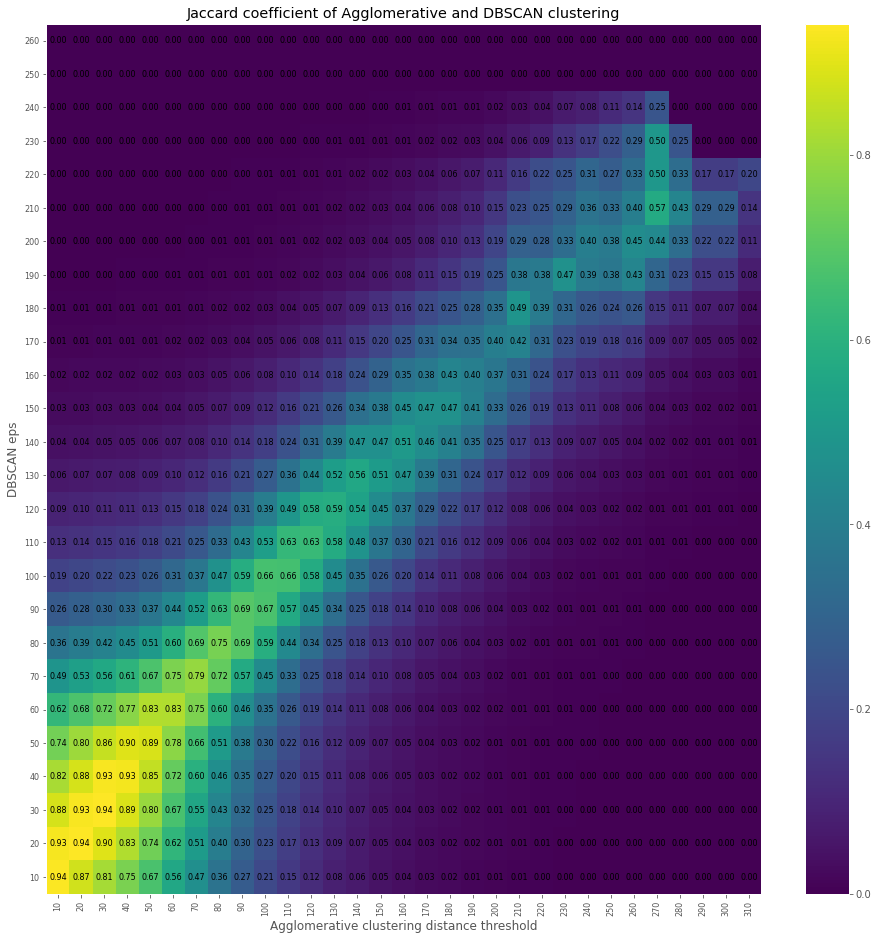

In [33]:
def JaccardSimilarity(A, B):
    div = len(set(A).union(B))
    if div > 0:
        return len(set(A).intersection(B)) / div
    else:
        return 0

def SorensenCoefficient(A, B):
    div = len(A) + len(B)
    if div > 0:
        return 2 * len(set(A).intersection(B)) / div
    else:
        return 0

def OverlapCoefficient(A, B):
    div = min(len(A),len(B))
    if div > 0:
        return len(set(A).intersection(B)) / div
    else:
        return 0

def similarity_dbscan_agglomerative(emb_array, w, v, all_files):
    import matplotlib.pyplot as plt
    import numpy as np

    #emb_array = np.load("../pca.res/emb_array_wybrane_3600.npy")
    #w = np.load("../pca.res/w_st_13804.npy")
    #v = np.load("../pca.res/v_st_13804.npy")
    #my_file = open("../pca.res/files.txt", "r")

    #file_content = my_file.read()
    #all_files = file_content.split("\n")

    eig_cumulative = np.copy(w) / np.sum(w)
    for a in range(1,eig_cumulative.shape[0]):
        eig_cumulative[a] += eig_cumulative[a - 1]
    end_coord = []
    a = 0
    while eig_cumulative[a] < 0.75:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.8:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.85:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.9:
        a = a + 1
    end_coord.append(a)
    while eig_cumulative[a] < 0.95:
        a = a + 1
    end_coord.append(a)


    for a in range(1, eig_cumulative.shape[0]):
        eig_cumulative[a] += eig_cumulative[a - 1]
    #start_coord = [0, 1, 2, 3, 4, 5, 10, 20]
    #start_coord = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    #start_coord = [0, 1, 2, 3, 4]
    #end_coord = [62]
    end_coord = [40]
    start_coord = [0]

    #min_samples = [3, 4, 5, 6, 7, 8]
    min_samples = [5]

    #eps = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    eps = list((np.asarray(range(26)) + 1) * 10)
    #eps = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    #eps = [1.8]


    print(sum(w / np.sum(w) * 100))

    #threshold = 1
    #p = 50
    all_files_names = all_files

    output_file = "results_dbscan/clusters"
    output_file_results = "results_dbscan/clusters.txt"
    all_results1 = []

    lbls1 = []

    for my_start_coord in start_coord:
        for my_end_coord in end_coord:
            if my_start_coord < my_end_coord:
                for my_eps in eps:
                    for my_min_samples in min_samples:
                        emb_array_copy = np.copy(emb_array[:, my_start_coord:my_end_coord])
                        ########################################################

                        output_file_ok = output_file + ",start=" + str(my_start_coord) + ",end=" + str(my_end_coord) \
                                         + ",eps=" + str(my_eps) + ",min_samples=" + str(my_min_samples) + ".txt"
                        help_results = []
                        with open(output_file_ok, 'r') as fp:
                            Lines = fp.readlines()
                            for line in Lines:
                                help_results.append(int(line))

                        all_results1.append(help_results)
                        #lbls.append("start=" + str(my_start_coord) + ",end=" + str(my_end_coord) \
                        #                 + ",eps=" + str(my_eps) + ",min_samples=" + str(my_min_samples))
                        lbls1.append(str(my_eps))


    output_file2 = "results_AgglomerativeClustering/clusters"
    output_file_results2 = "results_AgglomerativeClustering/clusters.txt"
    all_results2 = []

    lbls2 = []
    #distance_thresholds = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]
    distance_thresholds = list((np.asarray(range(31)) + 1) * 10)
    #distance_thresholds = [2.3]

    for my_start_coord in start_coord:
        for my_end_coord in end_coord:
            if my_start_coord < my_end_coord:
                for distance_threshold in distance_thresholds:
                        emb_array_copy = np.copy(emb_array[:, my_start_coord:my_end_coord])
                        ########################################################

                        output_file_ok = output_file2 + ",start=" + str(my_start_coord) + ",end=" + str(my_end_coord) \
                                         + ",distance_threshold=" + str(distance_threshold) + ".txt"
                        help_results = []
                        with open(output_file_ok, 'r') as fp:
                            Lines = fp.readlines()
                            for line in Lines:
                                help_results.append(int(line))

                        all_results2.append(help_results)
                        #lbls.append("start=" + str(my_start_coord) + ",end=" + str(my_end_coord) \
                        #                 + ",eps=" + str(my_eps) + ",min_samples=" + str(my_min_samples))
                        lbls2.append(str(distance_threshold))

    #plt.viridis()
    #fig, ax = plt.subplots(1)
    #plt.viridis()

    p = np.zeros((len(all_results1), len(all_results2)))

    #ax.pcolor(np.random.randn((10,10)))
    #ax.pcolor(np.random.randn(10), np.random.randn(10))

    for a in range(0, len(all_results1)):
        #for b in range(a + 1, len(all_results2)):
        for b in range(0, len(all_results2)):
            p[a,b] = OverlapCoefficient(all_results1[a], all_results2[b])
            p[a, b] = SorensenCoefficient(all_results1[a], all_results2[b])
            p[a, b] = JaccardSimilarity(all_results1[a], all_results2[b])
        #lbls.append(str(a))

    #p = ax.pcolormesh(np.random.randn(10,10))
    #p = ax.pcolormesh(p)
    #fig.colorbar(p)
    plt.figure(figsize=(16, 16))
    cm = plt.pcolormesh(p)
    plt.colorbar(cm)



    plt.yticks(np.arange(0.5, len(lbls1) + 0.5), lbls1,fontsize=8)
    plt.xticks(np.arange(0.5, len(lbls2) + 0.5), lbls2, rotation=90, fontsize=8)

    plt.xlabel("Agglomerative clustering distance threshold")
    plt.ylabel("DBSCAN eps")
    plt.title("Overlap coefficient of Agglomerative and DBSCAN clustering")
    plt.title("Sorensen coefficient of Agglomerative and DBSCAN clustering")
    plt.title("Jaccard coefficient of Agglomerative and DBSCAN clustering")

    #for a in range(0, len(all_results)):
    #    for b in range(a + 1, len(all_results)):
    for a in range(len(all_results1)):
        for b in range(len(all_results2)):
            #if a > b:
                plt.text(b+0.5,(a+0.5),"{:.2f}".format((p[a,b])),
                    ha='center',va='center',
                    size=8,color='black')

    plt.show()

similarity_dbscan_agglomerative(tnd_embedding, tracks_w, tracks_v_correct, np.hstack([dots_files, tracks_files, worms_files]))